In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import math

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
game_data = pd.read_csv('/Users/cgiess/Downloads/nfl-big-data-bowl-2023/games.csv')
players = pd.read_csv('/Users/cgiess/Downloads/nfl-big-data-bowl-2023/players.csv')
plays = pd.read_csv('/Users/cgiess/Downloads/nfl-big-data-bowl-2023/plays.csv')

# excluding duplicate playid for the game
c1 = (plays['gameId'] == 2021110100)
c2 = (plays['playId'] == 1267)
c3 = (plays['offenseFormation'] == 'SINGLEBACK')
plays = plays[~(c1&c2&c3)]

pff = pd.read_csv('/Users/cgiess/Downloads/nfl-big-data-bowl-2023/pffScoutingData.csv')

In [3]:
week1 = pd.read_csv('/Users/cgiess/Downloads/nfl-big-data-bowl-2023/week1.csv')
week2 = pd.read_csv('/Users/cgiess/Downloads/nfl-big-data-bowl-2023/week2.csv')
week3 = pd.read_csv('/Users/cgiess/Downloads/nfl-big-data-bowl-2023/week3.csv')
week4 = pd.read_csv('/Users/cgiess/Downloads/nfl-big-data-bowl-2023/week4.csv')
week5 = pd.read_csv('/Users/cgiess/Downloads/nfl-big-data-bowl-2023/week5.csv')
week6 = pd.read_csv('/Users/cgiess/Downloads/nfl-big-data-bowl-2023/week6.csv')
week7 = pd.read_csv('/Users/cgiess/Downloads/nfl-big-data-bowl-2023/week7.csv')
week8 = pd.read_csv('/Users/cgiess/Downloads/nfl-big-data-bowl-2023/week8.csv')
frames = [week1,week2,week3,week4,week5,week6,week7,week8]
weeks = pd.concat(frames)

# Standardise Tables

In [4]:
# add info to PFF table
pff['reciever'] = np.where(pff['pff_role'] == 'Pass Route',1,0)
pff['blocking'] = np.where(pff['pff_nflIdBlockedPlayer'].notnull(),1,0)
pff['pressure'] = np.where(pff['pff_hit'] == 1,1,0)
pff['pressure'] = np.where(pff['pff_hurry'] == 1,1,pff['pressure'])
pff['pressure'] = np.where(pff['pff_sack'] == 1,1,pff['pressure'])
pff['sack'] = np.where(pff['pff_sack'] == 1,1,0)
pff['pass_rush'] = np.where(pff['pff_role'] == 'Pass Rush',1,0)

In [5]:
possession = pd.merge(plays, game_data, how='left', left_on=['gameId'], right_on=['gameId'])
possession = possession[['gameId','playId','possessionTeam','homeTeamAbbr','visitorTeamAbbr','yardlineNumber','yardlineSide']]
possession['possessionTeam_alt'] = "home"
possession.loc[possession.possessionTeam != possession.homeTeamAbbr, 'possessionTeam_alt'] = "away"
possession.head(3)

,gameId,playId,possessionTeam,homeTeamAbbr,visitorTeamAbbr,yardlineNumber,yardlineSide,possessionTeam_alt
0,2021090900,97,TB,TB,DAL,33,TB,home
1,2021090900,137,DAL,TB,DAL,2,DAL,away
2,2021090900,187,DAL,TB,DAL,34,DAL,away


In [6]:
#week1_v2 = pd.merge(week1, possession, how='left', left_on=['gameId','playId'], right_on=['gameId','playId'])
week1_v2 = pd.merge(weeks, possession, how='left', left_on=['gameId','playId'], right_on=['gameId','playId'])
week1_v2['PlayerTeam'] =week1_v2['team']
week1_v2['possessionTeam'] =week1_v2['possessionTeam_alt']
pt_conditions = [
    ((week1_v2['team'] == 'football')),
    ((week1_v2['team'] == week1_v2['homeTeamAbbr'])),
    ((week1_v2['team'] == week1_v2['visitorTeamAbbr'])),
    ]
pt_values = ['football','home','away']

week1_v2['PlayerTeam2'] = np.select(pt_conditions, pt_values)

week1_v3 = pd.merge(week1_v2, players[['nflId','officialPosition','displayName']], how='left', left_on=['nflId'], right_on=['nflId'])
week1_v3['displayName'] = np.where(week1_v3['team'] == 'football','Football',week1_v3['displayName'])
week1_v3['possessionTeam_alt'] = np.where(week1_v3['team'] == 'football','football',week1_v3['possessionTeam_alt'])

week1_v3 = week1_v3.rename(columns={'officialPosition': 'position','team': 'team2','PlayerTeam2':'team'})
week1_v3.head(1)

,gameId,playId,nflId,frameId,time,jerseyNumber,team2,playDirection,x,y,s,a,dis,o,dir,event,possessionTeam,homeTeamAbbr,visitorTeamAbbr,yardlineNumber,yardlineSide,possessionTeam_alt,PlayerTeam,team,position,displayName
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.3,0.03,165.16,84.99,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady


In [7]:
W = week1_v3
W['Dir_rad'] = np.mod(90 - W.dir, 360) * math.pi/180.0
W['ToLeft'] = W.playDirection == "left"
W['TeamOnOffense'] = "home"
#W.loc[W.possessionTeam != W.homeTeamAbbr, 'TeamOnOffense'] = "away" changed due to data
W.loc[W.team2 != W.homeTeamAbbr, 'TeamOnOffense'] = "away"
W['IsOnOffense'] = W.team == W.TeamOnOffense # Is player on offense?
W['YardLine_std'] = 100 - W.yardlineNumber
W['yardlineSide_ha'] = np.where(W['yardlineSide'] == W['homeTeamAbbr'],'home','away')
W.loc[W.yardlineSide_ha.fillna('') == W.possessionTeam,'YardLine_std'] = W.loc[W.yardlineSide_ha.fillna('') == W.possessionTeam,  'yardlineNumber'] #changed due to data

#W.loc[W.yardlineSide.fillna('') == W.team2,'YardLine_std'] = W.loc[W.yardlineSide.fillna('') == W.team2,  'yardlineNumber']
W['X_std'] = W.x
W.loc[W.ToLeft, 'X_std'] = 120 - W.loc[W.ToLeft, 'x'] 
W['Y_std'] = W.y
W.loc[W.ToLeft, 'Y_std'] = 160/3 - W.loc[W.ToLeft, 'y'] 
#W['Orientation_std'] = -90 + W.Orientation
#W.loc[W.ToLeft, 'Orientation_std'] = np.mod(180 + W.loc[W.ToLeft, 'Orientation_std'], 360)
W['Dir_std'] = W.Dir_rad
W.loc[W.ToLeft, 'Dir_std'] = np.mod(np.pi + W.loc[W.ToLeft, 'Dir_rad'], 2*np.pi)
W['dx'] = round(W['s']*np.cos(W['Dir_std']),2)
W['dy'] = round(W['s']*np.sin(W['Dir_std']),2)
W['X_std'] = round(W['X_std'],2)
W['Y_std'] = round(W['Y_std'],2)
#W['Orientation_rad'] = np.mod(W.o, 360) * math.pi/180.0
W['Orientation_rad'] = np.mod(-W.o + 90, 360) * math.pi/180.0
W['Orientation_std'] = W.Orientation_rad
W.loc[W.ToLeft, 'Orientation_std'] = np.mod(np.pi + W.loc[W.ToLeft, 'Orientation_rad'], 2*np.pi)
W['Orientation_deg_std'] = np.rad2deg(W['Orientation_std'])
W['Dir_deg_std'] = np.rad2deg(W['Dir_std'])
W['MPH'] = W['s'] / 0.488889
# secondary modifications
W['time']= W['time']+'Z'

Standardised  = W
Standardised['X_std_true'] = Standardised['X_std'] - (Standardised['YardLine_std']+10) # want to centre X axis on 0 for consistency
Standardised['Y_std_true'] = Standardised['Y_std']

ball_snap_frame_min = Standardised[Standardised['event'].isin(['autoevent_ballsnap','ball_snap'])].groupby(['gameId','playId']).agg({'frameId':'min'})
ball_snap_frame_min.reset_index( drop=False, inplace=True )
ball_snap_frame_min = ball_snap_frame_min.rename(columns={'frameId': 'min_ball_snap_frameId'})
ball_snap_frame_max = Standardised[Standardised['event'].isin(['autoevent_ballsnap','ball_snap'])].groupby(['gameId','playId']).agg({'frameId':'max'})
ball_snap_frame_max.reset_index( drop=False, inplace=True )
ball_snap_frame_max = ball_snap_frame_max.rename(columns={'frameId': 'max_ball_snap_frameId'})

ball_snap_frame_min['max_ball_snap_frameId'] = ball_snap_frame_max['max_ball_snap_frameId']
ball_snap_frame_min['ball_snap_diff'] = ball_snap_frame_min['max_ball_snap_frameId'] - ball_snap_frame_min['min_ball_snap_frameId']
ball_snap_frame_min['ball_snap_frameId'] = np.where(ball_snap_frame_min['ball_snap_diff'] > 7,ball_snap_frame_min['max_ball_snap_frameId'],ball_snap_frame_min['min_ball_snap_frameId'] )
ball_snap_frame = ball_snap_frame_min[['gameId','playId','ball_snap_frameId']]

Standardised = pd.merge(Standardised, ball_snap_frame, how='left', on = ['gameId','playId'])
Standardised.head(3)

,gameId,playId,nflId,frameId,time,jerseyNumber,team2,playDirection,x,y,s,a,dis,o,dir,event,possessionTeam,homeTeamAbbr,visitorTeamAbbr,yardlineNumber,yardlineSide,possessionTeam_alt,PlayerTeam,team,position,displayName,Dir_rad,ToLeft,TeamOnOffense,IsOnOffense,YardLine_std,yardlineSide_ha,X_std,Y_std,Dir_std,dx,dy,Orientation_rad,Orientation_std,Orientation_deg_std,Dir_deg_std,MPH,X_std_true,Y_std_true,ball_snap_frameId
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100Z,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady,0.087441,False,home,True,33,home,37.77,24.22,0.087441,0.29,0.03,4.971396,4.971396,284.84,5.01,0.593182,-5.23,24.22,6.0
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200Z,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady,6.233094,False,home,True,33,home,37.78,24.22,6.233094,0.23,-0.01,4.985882,4.985882,285.67,357.13,0.470454,-5.22,24.22,6.0
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300Z,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady,0.374373,False,home,True,33,home,37.78,24.24,0.374373,0.15,0.06,5.057266,5.057266,289.76,21.45,0.327273,-5.22,24.24,6.0


In [8]:
f1 = (Standardised['frameId'] == 1)
f2 = (Standardised['position'].isin(['T','G','C']))
f3 = (Standardised['displayName'] == 'Football')
columns = ['gameId','playId','frameId','nflId','position','X_std_true','Y_std_true']
columns2 = ['gameId','playId','frameId','X_std_true','Y_std_true']

OL = Standardised[f1&f2][columns]
OL['is_C'] = np.where (OL['position'] == 'C',1,0)
OL_wC = OL.groupby(['gameId','playId','frameId']).agg({'is_C':'sum'})
OL_wC.reset_index( drop=False, inplace=True )
OL_wC = OL_wC.rename(columns={'is_C': 'C_in_play'})

FB = Standardised[f1&f3][columns2]
FB = FB.rename(columns={'X_std_true': 'FB_X_std_true','Y_std_true': 'FB_Y_std_true'})

OL2 = pd.merge(OL, OL_wC, how='left', on = ['gameId','playId','frameId'])
OL3 = pd.merge(OL2, FB, how='left', on = ['gameId','playId','frameId'])
OL3['dis_to_ball'] = ((OL3['X_std_true']-OL3['FB_X_std_true'])**2 + (OL3['Y_std_true']-OL3['FB_Y_std_true'])**2)**(1/2)
OL3['C_rank'] = OL3.groupby(['gameId','playId','frameId','is_C'])['dis_to_ball'].rank(method="first", ascending=True)
OL3['non_C_rank'] = OL3.groupby(['gameId','playId','frameId'])['X_std_true'].rank(method="first", ascending=False)
OL3['Is_C'] = np.where((OL3['C_in_play'] >= 1)&(OL3['is_C'] == 1)&(OL3['C_rank'] == 1),1,0)
OL3['Is_C'] = np.where((OL3['C_in_play'] == 0)&(OL3['non_C_rank'] == 1),1,OL3['Is_C'])
OL3['Snap_pos'] = OL3.groupby(['gameId','playId','frameId'])['Y_std_true'].rank(method="first", ascending=False)

OL3.head(10)

,gameId,playId,frameId,nflId,position,X_std_true,Y_std_true,is_C,C_in_play,FB_X_std_true,FB_Y_std_true,dis_to_ball,C_rank,non_C_rank,Is_C,Snap_pos
0,2021090900,97,1,40151.0,C,-0.82,23.97,1,1,-0.08,24.04,0.743303,1.0,1.0,1,3.0
1,2021090900,97,1,42377.0,T,-1.45,26.89,0,1,-0.08,24.04,3.162183,3.0,3.0,0,1.0
2,2021090900,97,1,42404.0,G,-1.05,25.66,0,1,-0.08,24.04,1.888200,1.0,2.0,0,2.0
3,2021090900,97,1,46163.0,G,-1.58,22.63,0,1,-0.08,24.04,2.058665,2.0,4.0,0,4.0
4,2021090900,97,1,52421.0,T,-1.85,21.36,0,1,-0.08,24.04,3.211744,4.0,5.0,0,5.0
5,2021090900,137,1,37082.0,T,-1.61,32.91,0,1,-0.06,29.83,3.448028,3.0,4.0,0,1.0
6,2021090900,137,1,42654.0,T,-1.88,26.85,0,1,-0.06,29.83,3.491819,4.0,5.0,0,5.0
7,2021090900,137,1,46119.0,G,-1.34,31.21,0,1,-0.06,29.83,1.882233,2.0,3.0,0,2.0
8,2021090900,137,1,47873.0,G,-0.72,28.59,0,1,-0.06,29.83,1.404706,1.0,1.0,0,4.0
9,2021090900,137,1,52554.0,C,-1.31,28.83,1,1,-0.06,29.83,1.600781,1.0,2.0,1,3.0


In [9]:
frame1_fb = Standardised[(Standardised['frameId'] == 1)&(Standardised['displayName'] == 'Football')][['gameId','playId','X_std_true']]
frame1_fb = frame1_fb.rename(columns={'X_std_true': 'FB_f1_X_std_true'})

frame_bs_fb = Standardised[(Standardised['frameId'] == Standardised['ball_snap_frameId'])&(Standardised['displayName'] == 'Football')][['gameId','playId','X_std_true']]
frame_bs_fb = frame_bs_fb.rename(columns={'X_std_true': 'FB_bs_X_std_true'})
frame_bs_fb.head(3)

,gameId,playId,FB_bs_X_std_true
951,2021090900,97,-1.44
1808,2021090900,137,0.18
2527,2021090900,187,-2.21


In [10]:
frame1_ol = Standardised[(Standardised['frameId'] == 1)&(Standardised['position'].isin(['T','G','C']))].groupby(['gameId','playId']).agg({'X_std_true':'max'})
frame1_ol.reset_index( drop=False, inplace=True )
frame1_ol = frame1_ol.rename(columns={'X_std_true': 'OL_f1_max_X_std_true'})

frame_bs_ol = Standardised[(Standardised['frameId'] == Standardised['ball_snap_frameId'])&(Standardised['position'].isin(['T','G','C']))].groupby(['gameId','playId']).agg({'X_std_true':'max'})
frame_bs_ol.reset_index( drop=False, inplace=True )
frame_bs_ol = frame_bs_ol.rename(columns={'X_std_true': 'OL_bs_max_X_std_true'})
frame_bs_ol.head(3)

,gameId,playId,OL_bs_max_X_std_true
0,2021090900,97,-0.90
1,2021090900,137,-0.74
2,2021090900,187,-1.67


In [11]:
df1 = pd.merge(frame1_fb, frame_bs_fb, how='left', on = ['gameId','playId'])
df2 = pd.merge(df1, frame1_ol, how='left', on = ['gameId','playId'])
df3 = pd.merge(df2, frame_bs_ol, how='left', on = ['gameId','playId'])
df3['ball_ahead_f1'] = np.where(df3['FB_f1_X_std_true']> df3['OL_f1_max_X_std_true'],1,0)
df3['ball_ahead_bs'] = np.where(df3['FB_bs_X_std_true']> df3['OL_bs_max_X_std_true'],1,0)
df3.head(5)

,gameId,playId,FB_f1_X_std_true,FB_bs_X_std_true,OL_f1_max_X_std_true,OL_bs_max_X_std_true,ball_ahead_f1,ball_ahead_bs
0,2021090900,97,-0.08,-1.44,-0.82,-0.90,1,0
1,2021090900,137,-0.06,0.18,-0.72,-0.74,1,1
2,2021090900,187,-0.47,-2.21,-1.55,-1.67,1,0
3,2021090900,282,-0.20,-1.19,-0.70,-0.82,1,0
4,2021090900,349,-0.15,-0.07,-0.82,-0.93,1,1


In [13]:
columns = ['gameId','playId','X_std_true','Y_std_true']

f1 = (OL3['frameId'] == 1)
f2 = (OL3['Is_C'] == 1)

centre_original_locarion = OL3[f1&f2][columns]
centre_original_locarion = centre_original_locarion.rename(columns={'X_std_true': 'C_X_std_true','Y_std_true': 'C_Y_std_true'})
centre_original_locarion.head(10)

,gameId,playId,C_X_std_true,C_Y_std_true
0,2021090900,97,-0.82,23.97
9,2021090900,137,-1.31,28.83
14,2021090900,187,-1.55,26.79
19,2021090900,282,-0.70,23.18
24,2021090900,349,-0.82,23.20
25,2021090900,410,-0.98,26.75
30,2021090900,434,-0.75,27.32
35,2021090900,456,-0.86,27.08
40,2021090900,480,-0.64,29.99
45,2021090900,509,-0.60,23.95


In [14]:
Standardised_v2 = pd.merge(Standardised, centre_original_locarion, how='left', left_on=['gameId','playId'], right_on=['gameId','playId'])
Standardised_v2['X_normal'] = Standardised_v2['X_std_true'] - Standardised_v2['C_X_std_true']
Standardised_v2['Y_normal'] = Standardised_v2['Y_std_true'] - Standardised_v2['C_Y_std_true']
Standardised_v2['is_a_QB'] = np.where(Standardised_v2['position'] == 'QB',1,0)

t = Standardised_v2[Standardised_v2['frameId'] == 1]
t['dis_to_C'] = ((t['X_normal'])**2 + (t['Y_normal'])**2)**(1/2)
t['qb_rank'] = t.groupby(['gameId','playId','is_a_QB'])['dis_to_C'].rank(method="first", ascending=True)
t['is_the_qb'] = np.where((t['is_a_QB'] == 1)&(t['qb_rank'] == 1),1,0)
is_qb = t[['gameId','playId','nflId','is_the_qb']]

Standardised_v2 = pd.merge(Standardised_v2, is_qb, how='left', left_on=['gameId','playId','nflId'], right_on=['gameId','playId','nflId'])

QB_frame_loc = Standardised_v2[Standardised_v2['is_the_qb'] == 1][['gameId','playId','frameId','X_normal','Y_normal']]
QB_frame_loc = QB_frame_loc.rename(columns={'X_normal': 'QB_loc_X_normal','Y_normal': 'QB_loc_Y_normal'})
Standardised_v2 = pd.merge(Standardised_v2, QB_frame_loc, how='left', on=['gameId','playId','frameId'])

Standardised_v2['dis_to_QB'] = ((Standardised_v2['X_normal']-Standardised_v2['QB_loc_X_normal'])**2 + (Standardised_v2['Y_normal']-Standardised_v2['QB_loc_Y_normal'])**2)**(1/2)
Standardised_v2.head(5)

,gameId,playId,nflId,frameId,time,jerseyNumber,team2,playDirection,x,y,s,a,dis,o,dir,event,possessionTeam,homeTeamAbbr,visitorTeamAbbr,yardlineNumber,yardlineSide,possessionTeam_alt,PlayerTeam,team,position,displayName,Dir_rad,ToLeft,TeamOnOffense,IsOnOffense,YardLine_std,yardlineSide_ha,X_std,Y_std,Dir_std,dx,dy,Orientation_rad,Orientation_std,Orientation_deg_std,Dir_deg_std,MPH,X_std_true,Y_std_true,ball_snap_frameId,C_X_std_true,C_Y_std_true,X_normal,Y_normal,is_a_QB,is_the_qb,QB_loc_X_normal,QB_loc_Y_normal,dis_to_QB
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100Z,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady,0.087441,False,home,True,33,home,37.77,24.22,0.087441,0.29,0.03,4.971396,4.971396,284.84,5.01,0.593182,-5.23,24.22,6.0,-0.82,23.97,-4.41,0.25,1,1,-4.41,0.25,0.0
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200Z,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady,6.233094,False,home,True,33,home,37.78,24.22,6.233094,0.23,-0.01,4.985882,4.985882,285.67,357.13,0.470454,-5.22,24.22,6.0,-0.82,23.97,-4.40,0.25,1,1,-4.40,0.25,0.0
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300Z,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady,0.374373,False,home,True,33,home,37.78,24.24,0.374373,0.15,0.06,5.057266,5.057266,289.76,21.45,0.327273,-5.22,24.24,6.0,-0.82,23.97,-4.40,0.27,1,1,-4.40,0.27,0.0
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400Z,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady,2.672972,False,home,True,33,home,37.73,24.25,2.672972,-0.13,0.07,5.198812,5.198812,297.87,153.15,0.306818,-5.27,24.25,6.0,-0.82,23.97,-4.45,0.28,1,1,-4.45,0.28,0.0
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500Z,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady,2.835287,False,home,True,33,home,37.69,24.26,2.835287,-0.24,0.08,5.265135,5.265135,301.67,162.45,0.511364,-5.31,24.26,6.0,-0.82,23.97,-4.49,0.29,1,1,-4.49,0.29,0.0


In [15]:
events = Standardised[~Standardised['event'].isin(['None'])].groupby(['gameId','playId','frameId','event']).agg({'time':'count'})
events.reset_index( drop=False, inplace=True )
events['shift'] = np.where(events['event'] == 'shift',1,0)
events['man_in_motion'] = np.where(events['event'] == 'man_in_motion',1,0)
events['play_action'] = np.where(events['event'] == 'play_action',1,0)
events['pre_ball_snap_event'] = np.where(events['event'].isin(['ball_snap','autoevent_ballsnap','line_set','man_in_motion','shift']),1,0)
events['ball_snap_event'] = np.where(events['event'].isin(['ball_snap','autoevent_ballsnap']),1,0)
events['post_ball_snap_event_ex_pa'] = np.where(~events['event'].isin(['ball_snap','autoevent_ballsnap','line_set','man_in_motion','shift','play_action']),1,0)

exclusion_list = ['fumble','handoff','lateral','qb_sack','qb_strip_sack','run','autoevent_passinterrupted','first_contact','fumble_offense_recovered']
events['exclusions'] = np.where(events['event'].isin(exclusion_list),1,0)
events['bs_rank'] = events.groupby(['gameId','playId','ball_snap_event'])['frameId'].rank(method="first", ascending=True)
events['post_bs_rank_ex_pa'] = events.groupby(['gameId','playId','post_ball_snap_event_ex_pa'])['frameId'].rank(method="first", ascending=True)
events.head(15)


,gameId,playId,frameId,event,time,shift,man_in_motion,play_action,pre_ball_snap_event,ball_snap_event,post_ball_snap_event_ex_pa,exclusions,bs_rank,post_bs_rank_ex_pa
0,2021090900,97,6,ball_snap,23,0,0,0,1,1,0,0,1.0,1.0
1,2021090900,97,38,autoevent_passforward,23,0,0,0,0,0,1,0,1.0,1.0
2,2021090900,97,40,pass_forward,23,0,0,0,0,0,1,0,2.0,2.0
3,2021090900,137,6,autoevent_ballsnap,23,0,0,0,1,1,0,0,1.0,1.0
4,2021090900,137,7,ball_snap,23,0,0,0,1,1,0,0,2.0,2.0
5,2021090900,137,32,pass_forward,23,0,0,0,0,0,1,0,1.0,1.0
6,2021090900,187,1,line_set,23,0,0,0,1,0,0,0,1.0,1.0
7,2021090900,187,6,ball_snap,23,0,0,0,1,1,0,0,1.0,2.0
8,2021090900,187,26,autoevent_passforward,23,0,0,0,0,0,1,0,2.0,1.0
9,2021090900,187,28,pass_forward,23,0,0,0,0,0,1,0,3.0,2.0


In [16]:
event_summary = events.groupby(['gameId','playId']).agg({'shift':'sum','man_in_motion':'sum','play_action':'sum','exclusions':'sum'})
event_summary.reset_index( drop=False, inplace=True )
event_summary['shift'] = np.where(event_summary['shift'] >= 1,1,0)
event_summary['man_in_motion'] = np.where(event_summary['man_in_motion'] >= 1,1,0)
event_summary['play_action'] = np.where(event_summary['play_action'] >= 1,1,0)
event_summary['exclusions'] = np.where(event_summary['exclusions'] >= 1,1,0)
event_summary.head(10)

,gameId,playId,shift,man_in_motion,play_action,exclusions
0,2021090900,97,0,0,0,0
1,2021090900,137,0,0,0,0
2,2021090900,187,0,0,0,0
3,2021090900,282,0,0,1,0
4,2021090900,349,0,0,0,0
5,2021090900,410,0,0,0,0
6,2021090900,434,0,0,0,0
7,2021090900,456,0,0,0,0
8,2021090900,480,0,0,0,0
9,2021090900,509,0,0,0,0


In [17]:
Standardised_v2_r = Standardised_v2[Standardised_v2['frameId'] == 1]
Standardised_v2_wr = pd.merge(Standardised_v2_r, pff[['gameId','playId','nflId','reciever','blocking']], how='left', on=['gameId','playId','nflId'])

c1 = (Standardised_v2_wr['reciever'] == 1.0)
c2 = (Standardised_v2_wr['X_normal'] >= -3.5)
c3 = (Standardised_v2_wr['blocking'] == 0.0)
Standardised_v2_wr['reciever2'] = np.where(c1 & c2 &c3,1,0)
Standardised_v2_wr_red = Standardised_v2_wr[['gameId','playId','nflId','reciever','blocking','reciever2']]
Standardised_v2_wr.head(3)

,gameId,playId,nflId,frameId,time,jerseyNumber,team2,playDirection,x,y,s,a,dis,o,dir,event,possessionTeam,homeTeamAbbr,visitorTeamAbbr,yardlineNumber,yardlineSide,possessionTeam_alt,PlayerTeam,team,position,displayName,Dir_rad,ToLeft,TeamOnOffense,IsOnOffense,YardLine_std,yardlineSide_ha,X_std,Y_std,Dir_std,dx,dy,Orientation_rad,Orientation_std,Orientation_deg_std,Dir_deg_std,MPH,X_std_true,Y_std_true,ball_snap_frameId,C_X_std_true,C_Y_std_true,X_normal,Y_normal,is_a_QB,is_the_qb,QB_loc_X_normal,QB_loc_Y_normal,dis_to_QB,reciever,blocking,reciever2
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100Z,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady,0.087441,False,home,True,33,home,37.77,24.22,0.087441,0.29,0.03,4.971396,4.971396,284.84,5.01,0.593182,-5.23,24.22,6.0,-0.82,23.97,-4.41,0.25,1,1,-4.41,0.25,0.000000,0.0,0.0,0
1,2021090900,97,35481.0,1,2021-09-10T00:26:31.100Z,87.0,TB,right,41.08,29.15,0.31,0.43,0.03,35.96,238.77,None,home,TB,DAL,33,TB,home,TB,home,TE,Rob Gronkowski,3.686659,False,home,True,33,home,41.08,29.15,3.686659,-0.27,-0.16,0.943176,0.943176,54.04,211.23,0.634091,-1.92,29.15,6.0,-0.82,23.97,-1.10,5.18,0,0,-4.41,0.25,5.938097,1.0,0.0,1
2,2021090900,97,35634.0,1,2021-09-10T00:26:31.100Z,81.0,TB,right,40.99,36.74,0.00,0.00,0.00,113.75,325.69,None,home,TB,DAL,33,TB,home,TB,home,WR,Antonio Brown,2.169619,False,home,True,33,home,40.99,36.74,2.169619,-0.00,0.00,5.868670,5.868670,336.25,124.31,0.000000,-2.01,36.74,6.0,-0.82,23.97,-1.19,12.77,0,0,-4.41,0.25,12.927444,1.0,0.0,1


In [18]:
pff_r_alt = Standardised_v2_wr.groupby(['gameId','playId']).agg({'reciever2':'sum'})
pff_r_alt.reset_index( drop=False, inplace=True )
pff_r_alt = pff_r_alt.rename(columns={'reciever2': 'total_reciever2'})
pff_r_alt.head(3)

,gameId,playId,total_reciever2
0,2021090900,97,4
1,2021090900,137,5
2,2021090900,187,4


In [19]:
QBs = Standardised_v2[(Standardised_v2['position'] == 'QB')]
QBs_f1 = QBs[(QBs['frameId'] == 1)]

QBs_f1 = pd.merge(QBs_f1, pff[['gameId','playId','nflId','pff_role','pff_positionLinedUp']], how='left', on=['gameId','playId','nflId'])
QBs_f1 = QBs_f1[QBs_f1['pff_positionLinedUp'] == 'QB']

QBs_f1['X_normal_round'] = QBs_f1['X_normal'].round(1)
QBs_f1['Shotgun'] = np.where(QBs_f1['X_normal_round'] < -2.5,1,0)
QB_S = QBs_f1[['gameId','playId','Shotgun']]
QB_S.head(3)

,gameId,playId,Shotgun
0,2021090900,97,1
1,2021090900,137,1
2,2021090900,187,1


In [20]:
def_min_to_qb = Standardised_v2[Standardised_v2['possessionTeam_alt'] != Standardised_v2['team']].groupby(['gameId','playId','nflId']).agg({'dis_to_QB':'min'})
def_min_to_qb.reset_index( drop=False, inplace=True )

testio = pd.merge(def_min_to_qb, pff, how='left', on=['gameId','playId','nflId'])
testio = testio[['gameId','playId','nflId','dis_to_QB','pff_hit','pff_hurry','pff_sack','pff_role','reciever','blocking','pressure','sack']]
testio.head(3)

,gameId,playId,nflId,dis_to_QB,pff_hit,pff_hurry,pff_sack,pff_role,reciever,blocking,pressure,sack
0,2021090900,97,41263.0,2.843835,0.0,1.0,0.0,Pass Rush,0,0,1,0
1,2021090900,97,42403.0,3.153173,0.0,1.0,0.0,Pass Rush,0,0,1,0
2,2021090900,97,43306.0,8.625010,0.0,0.0,0.0,Coverage,0,0,0,0


In [21]:
final = Standardised_v2
final['frame_post_snap'] = final['frameId']-final['ball_snap_frameId']
final = pd.merge(final, QB_S, how='left', on=['gameId','playId'])
final = pd.merge(final, event_summary, how='left', on=['gameId','playId'])
testio2 = testio[['gameId','playId','nflId','pressure','sack']]
final = pd.merge(final, testio2, how='left', on=['gameId','playId','nflId'])
final = pd.merge(final, Standardised_v2_wr_red, how='left', on=['gameId','playId','nflId'])
final = pd.merge(final, pff_r_alt, how='left', on=['gameId','playId'])
final['normal'] = np.where((final['Shotgun'] == 0)&(final['play_action'] == 0),1,0)
final['normal_pa'] = np.where((final['Shotgun'] == 0)&(final['play_action'] == 1),1,0)
final['shotgun'] = np.where((final['Shotgun'] == 1)&(final['play_action'] == 0),1,0)
final['shotgun_pa'] = np.where((final['Shotgun'] == 1)&(final['play_action'] == 1),1,0)
final['formation'] = np.where(final['normal'] == 1, 'normal','other')
final['formation'] = np.where((final['normal_pa'] == 1)&(final['formation'] == 'other'), 'normal PA',final['formation'])
final['formation'] = np.where((final['shotgun'] == 1)&(final['formation'] == 'other'), 'shotgun',final['formation'])
final['formation'] = np.where((final['shotgun_pa'] == 1)&(final['formation'] == 'other'), 'shotgun PA',final['formation'])
final = pd.merge(final, plays[['gameId','playId','down','yardsToGo','defendersInBox']], how='left', on = ['gameId','playId'])
final.head(5)

,gameId,playId,nflId,frameId,time,jerseyNumber,team2,playDirection,x,y,s,a,dis,o,dir,event,possessionTeam,homeTeamAbbr,visitorTeamAbbr,yardlineNumber,yardlineSide,possessionTeam_alt,PlayerTeam,team,position,displayName,Dir_rad,ToLeft,TeamOnOffense,IsOnOffense,YardLine_std,yardlineSide_ha,X_std,Y_std,Dir_std,dx,dy,Orientation_rad,Orientation_std,Orientation_deg_std,Dir_deg_std,MPH,X_std_true,Y_std_true,ball_snap_frameId,C_X_std_true,C_Y_std_true,X_normal,Y_normal,is_a_QB,is_the_qb,QB_loc_X_normal,QB_loc_Y_normal,dis_to_QB,frame_post_snap,Shotgun,shift,man_in_motion,play_action,exclusions,pressure,sack,reciever,blocking,reciever2,total_reciever2,normal,normal_pa,shotgun,shotgun_pa,formation,down,yardsToGo,defendersInBox
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100Z,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady,0.087441,False,home,True,33,home,37.77,24.22,0.087441,0.29,0.03,4.971396,4.971396,284.84,5.01,0.593182,-5.23,24.22,6.0,-0.82,23.97,-4.41,0.25,1,1,-4.41,0.25,0.0,-5.0,1,0,0,0,0,NaN,NaN,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200Z,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady,6.233094,False,home,True,33,home,37.78,24.22,6.233094,0.23,-0.01,4.985882,4.985882,285.67,357.13,0.470454,-5.22,24.22,6.0,-0.82,23.97,-4.40,0.25,1,1,-4.40,0.25,0.0,-4.0,1,0,0,0,0,NaN,NaN,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300Z,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady,0.374373,False,home,True,33,home,37.78,24.24,0.374373,0.15,0.06,5.057266,5.057266,289.76,21.45,0.327273,-5.22,24.24,6.0,-0.82,23.97,-4.40,0.27,1,1,-4.40,0.27,0.0,-3.0,1,0,0,0,0,NaN,NaN,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400Z,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady,2.672972,False,home,True,33,home,37.73,24.25,2.672972,-0.13,0.07,5.198812,5.198812,297.87,153.15,0.306818,-5.27,24.25,6.0,-0.82,23.97,-4.45,0.28,1,1,-4.45,0.28,0.0,-2.0,1,0,0,0,0,NaN,NaN,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500Z,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady,2.835287,False,home,True,33,home,37.69,24.26,2.835287,-0.24,0.08,5.265135,5.265135,301.67,162.45,0.511364,-5.31,24.26,6.0,-0.82,23.97,-4.49,0.29,1,1,-4.49,0.29,0.0,-1.0,1,0,0,0,0,NaN,NaN,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0


# Correct input data, e.g. standard time to throw

In [22]:
off_pass = final[(final['exclusions'] == 0)&(final['is_the_qb'] == 1)&(final['event'].isin(['autoevent_passforward','pass_forward']))]
off_pass_sum = off_pass.groupby(['gameId','playId','Shotgun','play_action','total_reciever2']).agg({'frame_post_snap':'min'})
off_pass_sum.reset_index( drop=False, inplace=True )
off_pass_sum.head(5)

,gameId,playId,Shotgun,play_action,total_reciever2,frame_post_snap
0,2021090900,97,1,0,4,32.0
1,2021090900,137,1,0,5,26.0
2,2021090900,187,1,0,4,20.0
3,2021090900,282,0,1,2,32.0
4,2021090900,349,1,0,3,26.0


In [23]:
play_info = plays[['gameId','playId','down','yardsToGo','passResult','dropBackType','penaltyYards','foulName1','defendersInBox']]
play_info['foul_in_play'] = np.where((play_info['foulName1'].notnull())|(play_info['penaltyYards'].notnull()),1,0)
play_info['pass_completed'] = np.where(play_info['passResult'] == 'C',1,0)
play_info.head(5)

,gameId,playId,down,yardsToGo,passResult,dropBackType,penaltyYards,foulName1,defendersInBox,foul_in_play,pass_completed
0,2021090900,97,3,2,I,TRADITIONAL,NaN,NaN,6.0,0,0
1,2021090900,137,1,10,C,TRADITIONAL,NaN,NaN,6.0,0,1
2,2021090900,187,2,6,C,TRADITIONAL,NaN,NaN,6.0,0,1
3,2021090900,282,1,10,I,TRADITIONAL,NaN,NaN,6.0,0,0
4,2021090900,349,3,15,I,TRADITIONAL,NaN,NaN,7.0,0,0


In [24]:
off_pass_sum2 = pd.merge(off_pass_sum, play_info, how='left', on = ['gameId','playId'])
#off_pass_sum2 = off_pass_sum2[off_pass_sum2['frame_post_snap'] <= 50] # long frame plays are generally data issues
off_pass_sum2.head(5)

,gameId,playId,Shotgun,play_action,total_reciever2,frame_post_snap,down,yardsToGo,passResult,dropBackType,penaltyYards,foulName1,defendersInBox,foul_in_play,pass_completed
0,2021090900,97,1,0,4,32.0,3,2,I,TRADITIONAL,NaN,NaN,6.0,0,0
1,2021090900,137,1,0,5,26.0,1,10,C,TRADITIONAL,NaN,NaN,6.0,0,1
2,2021090900,187,1,0,4,20.0,2,6,C,TRADITIONAL,NaN,NaN,6.0,0,1
3,2021090900,282,0,1,2,32.0,1,10,I,TRADITIONAL,NaN,NaN,6.0,0,0
4,2021090900,349,1,0,3,26.0,3,15,I,TRADITIONAL,NaN,NaN,7.0,0,0


In [25]:
pass_sum = off_pass_sum2[off_pass_sum2['pass_completed'] == 1].groupby(['Shotgun','play_action','total_reciever2']).agg({'frame_post_snap':'median','playId':'count'})
pass_sum.reset_index( drop=False, inplace=True )
pass_sum_red = pass_sum[pass_sum['playId']>10]
pass_sum_red['formation'] = np.where((pass_sum_red['Shotgun'] == 0)&(pass_sum_red['play_action'] == 0), 'normal','other')
pass_sum_red['formation'] = np.where((pass_sum_red['Shotgun'] == 0)&(pass_sum_red['play_action'] == 1)&(pass_sum_red['formation'] == 'other'), 'normal PA',pass_sum_red['formation'])
pass_sum_red['formation'] = np.where((pass_sum_red['Shotgun'] == 1)&(pass_sum_red['play_action'] == 0)&(pass_sum_red['formation'] == 'other'), 'shotgun',pass_sum_red['formation'])
pass_sum_red['formation'] = np.where((pass_sum_red['Shotgun'] == 1)&(pass_sum_red['play_action'] == 1)&(pass_sum_red['formation'] == 'other'), 'shotgun PA',pass_sum_red['formation'])
pass_sum_red

,Shotgun,play_action,total_reciever2,frame_post_snap,playId,formation
1,0,0,2,26.0,23,normal
2,0,0,3,24.0,53,normal
3,0,0,4,21.0,83,normal
6,0,1,2,34.0,251,normal PA
7,0,1,3,32.0,282,normal PA
8,0,1,4,28.0,125,normal PA
10,1,0,2,29.0,28,shotgun
11,1,0,3,30.0,447,shotgun
12,1,0,4,25.0,2211,shotgun
13,1,0,5,23.0,631,shotgun


In [407]:
completed_pass = off_pass_sum2[off_pass_sum2['pass_completed'] == 1]
completed_pass['normal'] = np.where((completed_pass['Shotgun'] == 0)&(completed_pass['play_action'] == 0),1,0)
completed_pass['normal_pa'] = np.where((completed_pass['Shotgun'] == 0)&(completed_pass['play_action'] == 1),1,0)
completed_pass['shotgun'] = np.where((completed_pass['Shotgun'] == 1)&(completed_pass['play_action'] == 0),1,0)
completed_pass['shotgun_pa'] = np.where((completed_pass['Shotgun'] == 1)&(completed_pass['play_action'] == 1),1,0)
# checked and redzone does not have a significant impact on time prediction
#completed_pass = pd.merge(completed_pass, plays[['gameId','playId','possessionTeam','defensiveTeam','yardlineSide','yardlineNumber','defendersInBox']], how='left', on=['gameId','playId'])
#completed_pass['in_redzone'] = np.where((completed_pass['yardlineSide'] == completed_pass['defensiveTeam'])&(completed_pass['yardlineNumber'] < 10),1,0)
completed_pass = completed_pass[~completed_pass['dropBackType'].isin(['SCRAMBLE','SCRAMBLE_ROLLOUT_LEFT','SCRAMBLE_ROLLOUT_RIGHT'])]
completed_pass = completed_pass[completed_pass['foul_in_play'] == 0]
completed_pass = completed_pass[completed_pass['down'] != 0]
completed_pass['des_roll'] = np.where(completed_pass['dropBackType'].isin(['DESIGNED_ROLLOUT_LEFT','DESIGNED_ROLLOUT_RIGHT']),1,0 )
completed_pass.reset_index( drop=False, inplace=True )
completed_pass.head(5)

,index,gameId,playId,Shotgun,play_action,total_reciever2,frame_post_snap,down,yardsToGo,passResult,dropBackType,penaltyYards,foulName1,defendersInBox,foul_in_play,pass_completed,normal,normal_pa,shotgun,shotgun_pa,des_roll
0,1,2021090900,137,1,0,5,26.0,1,10,C,TRADITIONAL,NaN,NaN,6.0,0,1,0,0,1,0,0
1,2,2021090900,187,1,0,4,20.0,2,6,C,TRADITIONAL,NaN,NaN,6.0,0,1,0,0,1,0,0
2,5,2021090900,410,1,0,5,16.0,2,5,C,TRADITIONAL,NaN,NaN,6.0,0,1,0,0,1,0,0
3,7,2021090900,456,1,0,4,25.0,2,10,C,TRADITIONAL,NaN,NaN,6.0,0,1,0,0,1,0,0
4,8,2021090900,480,1,0,4,34.0,1,10,C,TRADITIONAL,NaN,NaN,6.0,0,1,0,0,1,0,0


In [401]:
from sklearn.preprocessing import StandardScaler

In [409]:
scaler = StandardScaler()
x = completed_pass[['total_reciever2','down','yardsToGo','defendersInBox']]
scaler.fit(x)
x_scaled = scaler.transform(x)
x_scaled

array([[ 1.55203563, -1.08065046,  0.27811138, -0.01564826],
       [ 0.28479161,  0.12216308, -0.74002909, -0.01564826],
       [ 1.55203563,  0.12216308, -0.99456421, -0.01564826],
       ...,
       [-2.24969641, -1.08065046,  0.27811138,  0.98434998],
       [ 0.28479161,  1.32497663,  0.5326465 , -0.01564826],
       [ 0.28479161, -1.08065046,  0.27811138, -0.01564826]])

In [410]:
x_scaled_df = pd.DataFrame(x_scaled, columns = ['receiver_scaled','down_scaled','yards_to_go_scaled','defendersInBox_scaled'])
x_scaled_df.head(3)

,receiver_scaled,down_scaled,yards_to_go_scaled,defendersInBox_scaled
0,1.552036,-1.080650,0.278111,-0.015648
1,0.284792,0.122163,-0.740029,-0.015648
2,1.552036,0.122163,-0.994564,-0.015648


In [411]:
x.head(3)

,total_reciever2,down,yardsToGo,defendersInBox
0,5,1,10,6.0
1,4,2,6,6.0
2,5,2,5,6.0


In [412]:
completed_pass['receiver_scaled'] = x_scaled_df['receiver_scaled']
completed_pass['down_scaled'] = x_scaled_df['down_scaled']
completed_pass['yards_to_go_scaled'] = x_scaled_df['yards_to_go_scaled']
completed_pass['defendersInBox_scaled'] = x_scaled_df['defendersInBox_scaled']
completed_pass.head(3)

,index,gameId,playId,Shotgun,play_action,total_reciever2,frame_post_snap,down,yardsToGo,passResult,dropBackType,penaltyYards,foulName1,defendersInBox,foul_in_play,pass_completed,normal,normal_pa,shotgun,shotgun_pa,des_roll,receiver_scaled,down_scaled,yards_to_go_scaled,defendersInBox_scaled
0,1,2021090900,137,1,0,5,26.0,1,10,C,TRADITIONAL,NaN,NaN,6.0,0,1,0,0,1,0,0,1.552036,-1.080650,0.278111,-0.015648
1,2,2021090900,187,1,0,4,20.0,2,6,C,TRADITIONAL,NaN,NaN,6.0,0,1,0,0,1,0,0,0.284792,0.122163,-0.740029,-0.015648
2,5,2021090900,410,1,0,5,16.0,2,5,C,TRADITIONAL,NaN,NaN,6.0,0,1,0,0,1,0,0,1.552036,0.122163,-0.994564,-0.015648


In [31]:
#pip install numpy==1.21.6

In [27]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [418]:
formula = 'frame_post_snap ~ normal + normal_pa + shotgun + shotgun_pa + total_reciever2 + down + yardsToGo + defendersInBox'
time_to_throw_model = smf.glm(formula = formula, data = completed_pass, family = sm.families.Gaussian()).fit()
print(time_to_throw_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        frame_post_snap   No. Observations:                 4013
Model:                            GLM   Df Residuals:                     4005
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                          35.833
Method:                          IRLS   Log-Likelihood:                -12871.
Date:                Sun, 08 Jan 2023   Deviance:                   1.4351e+05
Time:                        11:43:09   Pearson chi2:                 1.44e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2334
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          31.5139      0.913     

In [419]:
# test to see if standardising changes results. TLDR it does not
formula2 = 'frame_post_snap ~ normal + normal_pa + shotgun + shotgun_pa + receiver_scaled + down_scaled + yards_to_go_scaled + defendersInBox_scaled'
time_to_throw_model2 = smf.glm(formula = formula2, data = completed_pass, family = sm.families.Gaussian()).fit()
print(time_to_throw_model2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        frame_post_snap   No. Observations:                 4013
Model:                            GLM   Df Residuals:                     4005
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                          35.835
Method:                          IRLS   Log-Likelihood:                -12871.
Date:                Sun, 08 Jan 2023   Deviance:                   1.4351e+05
Time:                        11:43:12   Pearson chi2:                 1.44e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2333
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                21.75

In [420]:
completed_pass['model_predict_release'] = time_to_throw_model.predict(completed_pass)
completed_pass['model_predict_release2'] = time_to_throw_model2.predict(completed_pass)
completed_pass['mean_release'] = completed_pass['frame_post_snap'].mean()
completed_pass['mean_variance'] = completed_pass['mean_release']-completed_pass['frame_post_snap']
completed_pass['mean_variance'] = np.where(completed_pass['mean_variance']<0, completed_pass['mean_variance']*-1,completed_pass['mean_variance'])
completed_pass['model_variance'] = completed_pass['model_predict_release']-completed_pass['frame_post_snap']
completed_pass['model_variance'] = np.where(completed_pass['model_variance']<0, completed_pass['model_variance']*-1,completed_pass['model_variance'])
completed_pass['model_variance2'] = completed_pass['model_predict_release2']-completed_pass['frame_post_snap']
completed_pass['model_variance2'] = np.where(completed_pass['model_variance2']<0, completed_pass['model_variance2']*-1,completed_pass['model_variance2'])
completed_pass['mean_correct'] = np.where(completed_pass['mean_variance'] <= 5.0,1,0)
completed_pass['model_correct'] = np.where(completed_pass['model_variance'] <= 5.0,1,0)
completed_pass['model_correct2'] = np.where(completed_pass['model_variance2'] <= 5.0,1,0)
completed_pass.head(5)

,index,gameId,playId,Shotgun,play_action,total_reciever2,frame_post_snap,down,yardsToGo,passResult,dropBackType,penaltyYards,foulName1,defendersInBox,foul_in_play,pass_completed,normal,normal_pa,shotgun,shotgun_pa,des_roll,receiver_scaled,down_scaled,yards_to_go_scaled,defendersInBox_scaled,model_predict_release,model_predict_release2,mean_release,mean_variance,model_variance,model_variance2,mean_correct,model_correct,model_correct2
0,1,2021090900,137,1,0,5,26.0,1,10,C,TRADITIONAL,NaN,NaN,6.0,0,1,0,0,1,0,0,1.552036,-1.080650,0.278111,-0.015648,21.835193,21.835193,26.385899,0.385899,4.164807,4.164807,1,1,1
1,2,2021090900,187,1,0,4,20.0,2,6,C,TRADITIONAL,NaN,NaN,6.0,0,1,0,0,1,0,0,0.284792,0.122163,-0.740029,-0.015648,24.552026,24.552026,26.385899,6.385899,4.552026,4.552026,0,1,1
2,5,2021090900,410,1,0,5,16.0,2,5,C,TRADITIONAL,NaN,NaN,6.0,0,1,0,0,1,0,0,1.552036,0.122163,-0.994564,-0.015648,21.808630,21.808630,26.385899,10.385899,5.808630,5.808630,0,0,0
3,7,2021090900,456,1,0,4,25.0,2,10,C,TRADITIONAL,NaN,NaN,6.0,0,1,0,0,1,0,0,0.284792,0.122163,0.278111,-0.015648,25.142136,25.142136,26.385899,1.385899,0.142136,0.142136,1,1,1
4,8,2021090900,480,1,0,4,34.0,1,10,C,TRADITIONAL,NaN,NaN,6.0,0,1,0,0,1,0,0,0.284792,-1.080650,0.278111,-0.015648,24.431061,24.431061,26.385899,7.614101,9.568939,9.568939,0,0,0


In [421]:
completed_pass[completed_pass['model_variance'] != completed_pass['model_variance2']].head(5)

,index,gameId,playId,Shotgun,play_action,total_reciever2,frame_post_snap,down,yardsToGo,passResult,dropBackType,penaltyYards,foulName1,defendersInBox,foul_in_play,pass_completed,normal,normal_pa,shotgun,shotgun_pa,des_roll,receiver_scaled,down_scaled,yards_to_go_scaled,defendersInBox_scaled,model_predict_release,model_predict_release2,mean_release,mean_variance,model_variance,model_variance2,mean_correct,model_correct,model_correct2
0,1,2021090900,137,1,0,5,26.0,1,10,C,TRADITIONAL,NaN,NaN,6.0,0,1,0,0,1,0,0,1.552036,-1.080650,0.278111,-0.015648,21.835193,21.835193,26.385899,0.385899,4.164807,4.164807,1,1,1
1,2,2021090900,187,1,0,4,20.0,2,6,C,TRADITIONAL,NaN,NaN,6.0,0,1,0,0,1,0,0,0.284792,0.122163,-0.740029,-0.015648,24.552026,24.552026,26.385899,6.385899,4.552026,4.552026,0,1,1
2,5,2021090900,410,1,0,5,16.0,2,5,C,TRADITIONAL,NaN,NaN,6.0,0,1,0,0,1,0,0,1.552036,0.122163,-0.994564,-0.015648,21.808630,21.808630,26.385899,10.385899,5.808630,5.808630,0,0,0
3,7,2021090900,456,1,0,4,25.0,2,10,C,TRADITIONAL,NaN,NaN,6.0,0,1,0,0,1,0,0,0.284792,0.122163,0.278111,-0.015648,25.142136,25.142136,26.385899,1.385899,0.142136,0.142136,1,1,1
4,8,2021090900,480,1,0,4,34.0,1,10,C,TRADITIONAL,NaN,NaN,6.0,0,1,0,0,1,0,0,0.284792,-1.080650,0.278111,-0.015648,24.431061,24.431061,26.385899,7.614101,9.568939,9.568939,0,0,0


In [30]:
completed_pass['frame_post_snap'].mean()

26.385899352267064

In [31]:
completed_pass['model_predict_release'].mean()

26.38362138759544

In [32]:
print(completed_pass['mean_correct'].sum()/completed_pass['mean_correct'].count())

0.5187484479761609


In [422]:
print(completed_pass['model_correct'].sum()/completed_pass['model_correct'].count())

0.616588030792153


In [423]:
## Standardisation has zero impact for the GLM model
print(completed_pass['model_correct2'].sum()/completed_pass['model_correct2'].count())

0.616588030792153


In [39]:
print(31.5139+10.6196-2*2.5959+0.7111+10*0.1475-6*0.8425)

34.0728


In [43]:
print(31.5139+6.1693-(5*2.5959)+(3*0.7111)+(6*0.1475)+(5*-0.8425))

23.509499999999996


In [ ]:
completed_pass[[]]

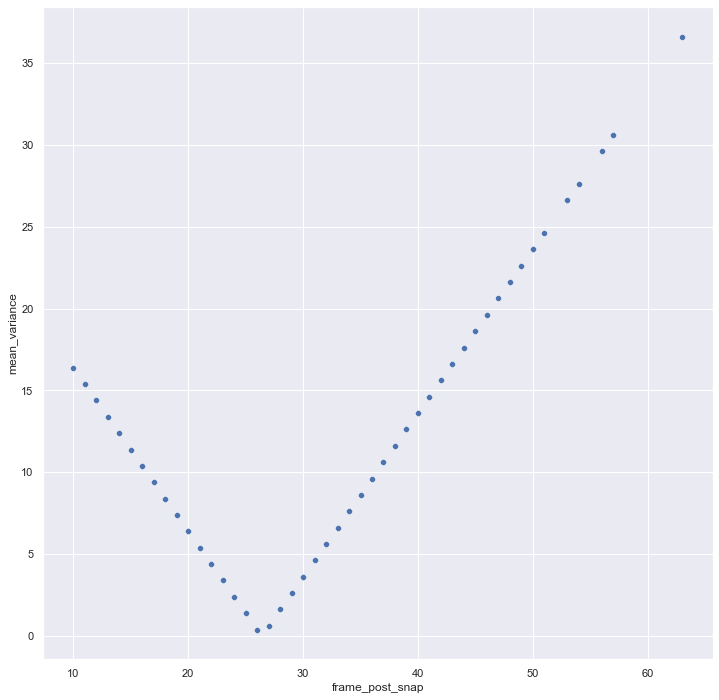

In [34]:
sns.set(rc={'figure.figsize':(12,12)})
c = sns.scatterplot(data=completed_pass, x = 'frame_post_snap' , y = 'mean_variance')
#c.set_xlim(0, 0.3)
#c.set_ylim(0, 0.3)

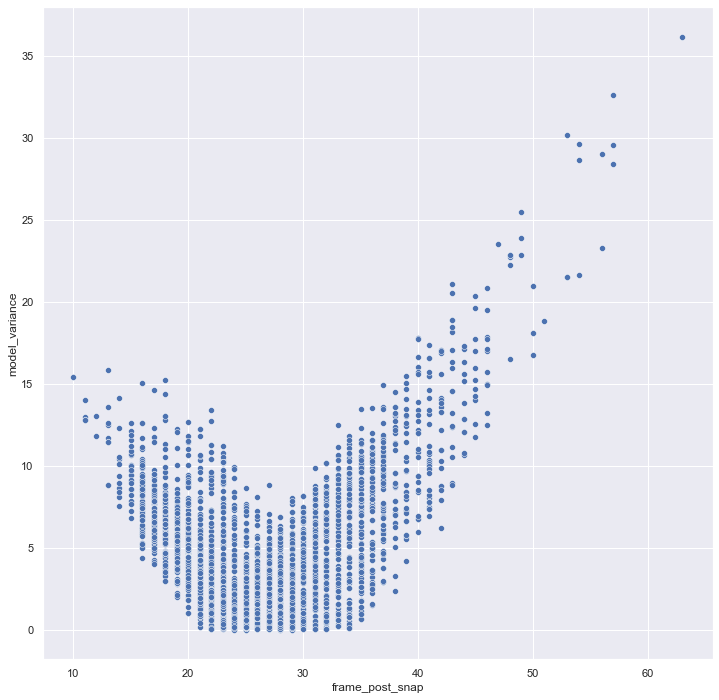

In [35]:
sns.set(rc={'figure.figsize':(12,12)})
c = sns.scatterplot(data=completed_pass, x = 'frame_post_snap' , y = 'model_variance')
#c.set_xlim(0, 0.3)
#c.set_ylim(0, 0.3)

# Correct pressure data with new time to throw

In [44]:
final['model_predict_release'] = time_to_throw_model.predict(final)
final.head(5)

,gameId,playId,nflId,frameId,time,jerseyNumber,team2,playDirection,x,y,s,a,dis,o,dir,event,possessionTeam,homeTeamAbbr,visitorTeamAbbr,yardlineNumber,yardlineSide,possessionTeam_alt,PlayerTeam,team,position,displayName,Dir_rad,ToLeft,TeamOnOffense,IsOnOffense,YardLine_std,yardlineSide_ha,X_std,Y_std,Dir_std,dx,dy,Orientation_rad,Orientation_std,Orientation_deg_std,Dir_deg_std,MPH,X_std_true,Y_std_true,ball_snap_frameId,C_X_std_true,C_Y_std_true,X_normal,Y_normal,is_a_QB,is_the_qb,QB_loc_X_normal,QB_loc_Y_normal,dis_to_QB,frame_post_snap,Shotgun,shift,man_in_motion,play_action,exclusions,pressure,sack,reciever,blocking,reciever2,total_reciever2,normal,normal_pa,shotgun,shotgun_pa,formation,down,yardsToGo,defendersInBox,model_predict_release
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100Z,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady,0.087441,False,home,True,33,home,37.77,24.22,0.087441,0.29,0.03,4.971396,4.971396,284.84,5.01,0.593182,-5.23,24.22,6.0,-0.82,23.97,-4.41,0.25,1,1,-4.41,0.25,0.0,-5.0,1,0,0,0,0,NaN,NaN,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200Z,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady,6.233094,False,home,True,33,home,37.78,24.22,6.233094,0.23,-0.01,4.985882,4.985882,285.67,357.13,0.470454,-5.22,24.22,6.0,-0.82,23.97,-4.40,0.25,1,1,-4.40,0.25,0.0,-4.0,1,0,0,0,0,NaN,NaN,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300Z,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady,0.374373,False,home,True,33,home,37.78,24.24,0.374373,0.15,0.06,5.057266,5.057266,289.76,21.45,0.327273,-5.22,24.24,6.0,-0.82,23.97,-4.40,0.27,1,1,-4.40,0.27,0.0,-3.0,1,0,0,0,0,NaN,NaN,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400Z,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady,2.672972,False,home,True,33,home,37.73,24.25,2.672972,-0.13,0.07,5.198812,5.198812,297.87,153.15,0.306818,-5.27,24.25,6.0,-0.82,23.97,-4.45,0.28,1,1,-4.45,0.28,0.0,-2.0,1,0,0,0,0,NaN,NaN,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500Z,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None,home,TB,DAL,33,TB,home,TB,home,QB,Tom Brady,2.835287,False,home,True,33,home,37.69,24.26,2.835287,-0.24,0.08,5.265135,5.265135,301.67,162.45,0.511364,-5.31,24.26,6.0,-0.82,23.97,-4.49,0.29,1,1,-4.49,0.29,0.0,-1.0,1,0,0,0,0,NaN,NaN,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991


In [45]:
pff_ba = pff[pff['pff_nflIdBlockedPlayer'].notnull()][['gameId','playId','nflId','pff_nflIdBlockedPlayer']]
pff_ba['ba_rank'] = pff_ba.groupby(['gameId','playId','pff_nflIdBlockedPlayer'])['nflId'].rank(method="first", ascending=True)

b_conditions = [
    (pff_ba['ba_rank'] == 1.0),
    (pff_ba['ba_rank'] == 2.0),
    (pff_ba['ba_rank'] == 3.0),
    (pff_ba['ba_rank'] == 4.0),
    ]
b_values = ['B1','B2','B3','B4']

# create a new column and use np.select to assign values to it using our lists as arguments
pff_ba['ba_rank_string'] = np.select(b_conditions, b_values)
pff_ba.head(10)

,gameId,playId,nflId,pff_nflIdBlockedPlayer,ba_rank,ba_rank_string
4,2021090900,97,40151,44955.0,1.0,B1
7,2021090900,97,42377,42403.0,1.0,B1
9,2021090900,97,42404,44955.0,2.0,B2
16,2021090900,97,46163,53441.0,1.0,B1
18,2021090900,97,52421,53441.0,2.0,B2
24,2021090900,137,37082,35454.0,1.0,B1
29,2021090900,137,42654,40074.0,1.0,B1
34,2021090900,137,46119,35441.0,1.0,B1
39,2021090900,137,47873,46081.0,1.0,B1
42,2021090900,137,52554,35441.0,2.0,B2


In [46]:
pff_ba_pivot = pff_ba.pivot_table('nflId', ['gameId', 'playId','pff_nflIdBlockedPlayer'], 'ba_rank_string')
pff_ba_pivot.reset_index( drop=False, inplace=True )
pff_ba_pivot.head(5)

ba_rank_string,gameId,playId,pff_nflIdBlockedPlayer,B1,B2,B3,B4
0,2021090900,97,42403.0,42377.0,NaN,NaN,NaN
1,2021090900,97,44955.0,40151.0,42404.0,NaN,NaN
2,2021090900,97,53441.0,46163.0,52421.0,NaN,NaN
3,2021090900,137,35441.0,46119.0,52554.0,NaN,NaN
4,2021090900,137,35454.0,37082.0,NaN,NaN,NaN


In [47]:
c1 = (final['possessionTeam_alt'] != final['team'])
c12 = (final['possessionTeam_alt'] == final['team'])
c2 = (final['frame_post_snap'] >= 0)
c3 = (final['frame_post_snap'] <= final['model_predict_release'])
c4 = (final['nflId'].notnull())

def_players = final[c1&c2&c3&c4]
off_players = final[c12&c2&c3&c4]
def_players.head(5)

,gameId,playId,nflId,frameId,time,jerseyNumber,team2,playDirection,x,y,s,a,dis,o,dir,event,possessionTeam,homeTeamAbbr,visitorTeamAbbr,yardlineNumber,yardlineSide,possessionTeam_alt,PlayerTeam,team,position,displayName,Dir_rad,ToLeft,TeamOnOffense,IsOnOffense,YardLine_std,yardlineSide_ha,X_std,Y_std,Dir_std,dx,dy,Orientation_rad,Orientation_std,Orientation_deg_std,Dir_deg_std,MPH,X_std_true,Y_std_true,ball_snap_frameId,C_X_std_true,C_Y_std_true,X_normal,Y_normal,is_a_QB,is_the_qb,QB_loc_X_normal,QB_loc_Y_normal,dis_to_QB,frame_post_snap,Shotgun,shift,man_in_motion,play_action,exclusions,pressure,sack,reciever,blocking,reciever2,total_reciever2,normal,normal_pa,shotgun,shotgun_pa,formation,down,yardsToGo,defendersInBox,model_predict_release
263,2021090900,97,41263.0,6,2021-09-10T00:26:31.600Z,90.0,DAL,right,43.30,18.89,0.96,0.90,0.11,316.48,288.76,ball_snap,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,2.814169,False,away,True,33,home,43.30,18.89,2.814169,-0.91,0.31,2.330364,2.330364,133.52,161.24,1.963636,0.30,18.89,6.0,-0.82,23.97,1.12,-5.08,0,0,-4.54,0.29,7.802083,0.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991
264,2021090900,97,41263.0,7,2021-09-10T00:26:31.700Z,90.0,DAL,right,43.19,18.91,1.08,0.86,0.12,308.13,282.13,None,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,2.929884,False,away,True,33,home,43.19,18.91,2.929884,-1.06,0.23,2.476099,2.476099,141.87,167.87,2.209090,0.19,18.91,6.0,-0.82,23.97,1.01,-5.06,0,0,-4.62,0.29,7.766557,1.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991
265,2021090900,97,41263.0,8,2021-09-10T00:26:31.800Z,90.0,DAL,right,43.03,18.93,1.30,0.85,0.16,310.58,277.08,None,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,3.018023,False,away,True,33,home,43.03,18.93,3.018023,-1.29,0.16,2.433338,2.433338,139.42,172.92,2.659090,0.03,18.93,6.0,-0.82,23.97,0.85,-5.04,0,0,-4.71,0.28,7.695193,2.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991
266,2021090900,97,41263.0,9,2021-09-10T00:26:31.900Z,90.0,DAL,right,42.87,18.98,1.48,0.79,0.17,312.75,279.62,None,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,2.973692,False,away,True,33,home,42.87,18.98,2.973692,-1.46,0.25,2.395464,2.395464,137.25,170.38,3.027272,-0.13,18.98,6.0,-0.82,23.97,0.69,-4.99,0,0,-4.80,0.27,7.603138,3.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991
267,2021090900,97,41263.0,10,2021-09-10T00:26:32.000Z,90.0,DAL,right,42.60,19.09,2.16,1.34,0.30,312.75,286.29,None,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,2.857279,False,away,True,33,home,42.60,19.09,2.857279,-2.07,0.61,2.395464,2.395464,137.25,163.71,4.418181,-0.40,19.09,6.0,-0.82,23.97,0.42,-4.88,0,0,-4.91,0.26,7.404627,4.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991


In [48]:
def_players_sum = def_players.groupby(['gameId','playId','nflId','position','pressure','sack','formation','reciever2','model_predict_release']).agg({'dis_to_QB':'min'})
def_players_sum.reset_index( drop=False, inplace=True )
def_players_sum['dis_to_QB_round'] = def_players_sum['dis_to_QB'].round(1)
def_players_sum.head(22)

,gameId,playId,nflId,position,pressure,sack,formation,reciever2,model_predict_release,dis_to_QB,dis_to_QB_round
0,2021090900,97,41263.0,DE,1.0,0.0,shotgun,0,24.672991,3.323206,3.3
1,2021090900,97,42403.0,DE,1.0,0.0,shotgun,0,24.672991,3.490129,3.5
2,2021090900,97,43306.0,MLB,0.0,0.0,shotgun,0,24.672991,8.687330,8.7
3,2021090900,97,43478.0,CB,0.0,0.0,shotgun,0,24.672991,14.633199,14.6
4,2021090900,97,44904.0,CB,0.0,0.0,shotgun,0,24.672991,13.371974,13.4
5,2021090900,97,44955.0,DE,0.0,0.0,shotgun,0,24.672991,5.494879,5.5
6,2021090900,97,44962.0,SS,0.0,0.0,shotgun,0,24.672991,21.548756,21.5
7,2021090900,97,47996.0,SS,0.0,0.0,shotgun,0,24.672991,10.592799,10.6
8,2021090900,97,52459.0,CB,0.0,0.0,shotgun,0,24.672991,10.140439,10.1
9,2021090900,97,53441.0,OLB,1.0,0.0,shotgun,0,24.672991,3.372017,3.4


In [49]:
def_players = pd.merge(def_players, pff_ba_pivot, how='left', left_on=['gameId','playId','nflId'], right_on=['gameId','playId','pff_nflIdBlockedPlayer'])
def_players.head(5)

,gameId,playId,nflId,frameId,time,jerseyNumber,team2,playDirection,x,y,s,a,dis,o,dir,event,possessionTeam,homeTeamAbbr,visitorTeamAbbr,yardlineNumber,yardlineSide,possessionTeam_alt,PlayerTeam,team,position,displayName,Dir_rad,ToLeft,TeamOnOffense,IsOnOffense,YardLine_std,yardlineSide_ha,X_std,Y_std,Dir_std,dx,dy,Orientation_rad,Orientation_std,Orientation_deg_std,Dir_deg_std,MPH,X_std_true,Y_std_true,ball_snap_frameId,C_X_std_true,C_Y_std_true,X_normal,Y_normal,is_a_QB,is_the_qb,QB_loc_X_normal,QB_loc_Y_normal,dis_to_QB,frame_post_snap,Shotgun,shift,man_in_motion,play_action,exclusions,pressure,sack,reciever,blocking,reciever2,total_reciever2,normal,normal_pa,shotgun,shotgun_pa,formation,down,yardsToGo,defendersInBox,model_predict_release,pff_nflIdBlockedPlayer,B1,B2,B3,B4
0,2021090900,97,41263.0,6,2021-09-10T00:26:31.600Z,90.0,DAL,right,43.30,18.89,0.96,0.90,0.11,316.48,288.76,ball_snap,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,2.814169,False,away,True,33,home,43.30,18.89,2.814169,-0.91,0.31,2.330364,2.330364,133.52,161.24,1.963636,0.30,18.89,6.0,-0.82,23.97,1.12,-5.08,0,0,-4.54,0.29,7.802083,0.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991,NaN,NaN,NaN,NaN,NaN
1,2021090900,97,41263.0,7,2021-09-10T00:26:31.700Z,90.0,DAL,right,43.19,18.91,1.08,0.86,0.12,308.13,282.13,None,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,2.929884,False,away,True,33,home,43.19,18.91,2.929884,-1.06,0.23,2.476099,2.476099,141.87,167.87,2.209090,0.19,18.91,6.0,-0.82,23.97,1.01,-5.06,0,0,-4.62,0.29,7.766557,1.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991,NaN,NaN,NaN,NaN,NaN
2,2021090900,97,41263.0,8,2021-09-10T00:26:31.800Z,90.0,DAL,right,43.03,18.93,1.30,0.85,0.16,310.58,277.08,None,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,3.018023,False,away,True,33,home,43.03,18.93,3.018023,-1.29,0.16,2.433338,2.433338,139.42,172.92,2.659090,0.03,18.93,6.0,-0.82,23.97,0.85,-5.04,0,0,-4.71,0.28,7.695193,2.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991,NaN,NaN,NaN,NaN,NaN
3,2021090900,97,41263.0,9,2021-09-10T00:26:31.900Z,90.0,DAL,right,42.87,18.98,1.48,0.79,0.17,312.75,279.62,None,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,2.973692,False,away,True,33,home,42.87,18.98,2.973692,-1.46,0.25,2.395464,2.395464,137.25,170.38,3.027272,-0.13,18.98,6.0,-0.82,23.97,0.69,-4.99,0,0,-4.80,0.27,7.603138,3.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991,NaN,NaN,NaN,NaN,NaN
4,2021090900,97,41263.0,10,2021-09-10T00:26:32.000Z,90.0,DAL,right,42.60,19.09,2.16,1.34,0.30,312.75,286.29,None,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,2.857279,False,away,True,33,home,42.60,19.09,2.857279,-2.07,0.61,2.395464,2.395464,137.25,163.71,4.418181,-0.40,19.09,6.0,-0.82,23.97,0.42,-4.88,0,0,-4.91,0.26,7.404627,4.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991,NaN,NaN,NaN,NaN,NaN


In [50]:
off_players_red = off_players[['gameId','playId','frameId','nflId','dis_to_QB']]
off_players_red1 = off_players_red.rename(columns={'nflId': 'B1_nflId','dis_to_QB': 'B1_dis_to_QB'})
off_players_red2 = off_players_red.rename(columns={'nflId': 'B2_nflId','dis_to_QB': 'B2_dis_to_QB'})
off_players_red3 = off_players_red.rename(columns={'nflId': 'B3_nflId','dis_to_QB': 'B3_dis_to_QB'})
off_players_red4 = off_players_red.rename(columns={'nflId': 'B4_nflId','dis_to_QB': 'B4_dis_to_QB'})
off_players_red.head(5)

,gameId,playId,frameId,nflId,dis_to_QB
5,2021090900,97,6,25511.0,0.0
6,2021090900,97,7,25511.0,0.0
7,2021090900,97,8,25511.0,0.0
8,2021090900,97,9,25511.0,0.0
9,2021090900,97,10,25511.0,0.0


In [51]:
def_players2 = pd.merge(def_players, off_players_red1, how='left', left_on=['gameId','playId','B1','frameId'], right_on=['gameId','playId','B1_nflId','frameId'])
def_players2 = pd.merge(def_players2, off_players_red2, how='left', left_on=['gameId','playId','B2','frameId'], right_on=['gameId','playId','B2_nflId','frameId'])
def_players2 = pd.merge(def_players2, off_players_red3, how='left', left_on=['gameId','playId','B3','frameId'], right_on=['gameId','playId','B3_nflId','frameId'])
def_players2 = pd.merge(def_players2, off_players_red4, how='left', left_on=['gameId','playId','B4','frameId'], right_on=['gameId','playId','B4_nflId','frameId'])
def_players2.head(5)

,gameId,playId,nflId,frameId,time,jerseyNumber,team2,playDirection,x,y,s,a,dis,o,dir,event,possessionTeam,homeTeamAbbr,visitorTeamAbbr,yardlineNumber,yardlineSide,possessionTeam_alt,PlayerTeam,team,position,displayName,Dir_rad,ToLeft,TeamOnOffense,IsOnOffense,YardLine_std,yardlineSide_ha,X_std,Y_std,Dir_std,dx,dy,Orientation_rad,Orientation_std,Orientation_deg_std,Dir_deg_std,MPH,X_std_true,Y_std_true,ball_snap_frameId,C_X_std_true,C_Y_std_true,X_normal,Y_normal,is_a_QB,is_the_qb,QB_loc_X_normal,QB_loc_Y_normal,dis_to_QB,frame_post_snap,Shotgun,shift,man_in_motion,play_action,exclusions,pressure,sack,reciever,blocking,reciever2,total_reciever2,normal,normal_pa,shotgun,shotgun_pa,formation,down,yardsToGo,defendersInBox,model_predict_release,pff_nflIdBlockedPlayer,B1,B2,B3,B4,B1_nflId,B1_dis_to_QB,B2_nflId,B2_dis_to_QB,B3_nflId,B3_dis_to_QB,B4_nflId,B4_dis_to_QB
0,2021090900,97,41263.0,6,2021-09-10T00:26:31.600Z,90.0,DAL,right,43.30,18.89,0.96,0.90,0.11,316.48,288.76,ball_snap,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,2.814169,False,away,True,33,home,43.30,18.89,2.814169,-0.91,0.31,2.330364,2.330364,133.52,161.24,1.963636,0.30,18.89,6.0,-0.82,23.97,1.12,-5.08,0,0,-4.54,0.29,7.802083,0.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021090900,97,41263.0,7,2021-09-10T00:26:31.700Z,90.0,DAL,right,43.19,18.91,1.08,0.86,0.12,308.13,282.13,None,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,2.929884,False,away,True,33,home,43.19,18.91,2.929884,-1.06,0.23,2.476099,2.476099,141.87,167.87,2.209090,0.19,18.91,6.0,-0.82,23.97,1.01,-5.06,0,0,-4.62,0.29,7.766557,1.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021090900,97,41263.0,8,2021-09-10T00:26:31.800Z,90.0,DAL,right,43.03,18.93,1.30,0.85,0.16,310.58,277.08,None,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,3.018023,False,away,True,33,home,43.03,18.93,3.018023,-1.29,0.16,2.433338,2.433338,139.42,172.92,2.659090,0.03,18.93,6.0,-0.82,23.97,0.85,-5.04,0,0,-4.71,0.28,7.695193,2.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021090900,97,41263.0,9,2021-09-10T00:26:31.900Z,90.0,DAL,right,42.87,18.98,1.48,0.79,0.17,312.75,279.62,None,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,2.973692,False,away,True,33,home,42.87,18.98,2.973692,-1.46,0.25,2.395464,2.395464,137.25,170.38,3.027272,-0.13,18.98,6.0,-0.82,23.97,0.69,-4.99,0,0,-4.80,0.27,7.603138,3.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021090900,97,41263.0,10,2021-09-10T00:26:32.000Z,90.0,DAL,right,42.60,19.09,2.16,1.34,0.30,312.75,286.29,None,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,2.857279,False,away,True,33,home,42.60,19.09,2.857279,-2.07,0.61,2.395464,2.395464,137.25,163.71,4.418181,-0.40,19.09,6.0,-0.82,23.97,0.42,-4.88,0,0,-4.91,0.26,7.404627,4.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
def_players2['B1_dis_to_QB'] = np.where(def_players2['B1_dis_to_QB'].isnull(),15,def_players2['B1_dis_to_QB'])
def_players2['B2_dis_to_QB'] = np.where(def_players2['B2_dis_to_QB'].isnull(),15,def_players2['B2_dis_to_QB'])
def_players2['B3_dis_to_QB'] = np.where(def_players2['B3_dis_to_QB'].isnull(),15,def_players2['B3_dis_to_QB'])
def_players2['B4_dis_to_QB'] = np.where(def_players2['B4_dis_to_QB'].isnull(),15,def_players2['B4_dis_to_QB'])

c1 = (def_players2['B1_nflId'].notnull())
c2 = (def_players2['dis_to_QB'] < def_players2['B1_dis_to_QB'])
c3 = (def_players2['dis_to_QB'] < def_players2['B2_dis_to_QB'])
c4 = (def_players2['dis_to_QB'] < def_players2['B3_dis_to_QB'])
c5 = (def_players2['dis_to_QB'] < def_players2['B4_dis_to_QB'])

def_players2['closer_than_block'] = np.where(c1&c2&c3&c4&c5,1,0)
def_players2['assigned_block'] = np.where(c1,1,0)
def_players2['assigned_blockers'] = np.where((def_players2['B2_nflId'].notnull()),2,def_players2['assigned_block'])
def_players2.head(50)

,gameId,playId,nflId,frameId,time,jerseyNumber,team2,playDirection,x,y,s,a,dis,o,dir,event,possessionTeam,homeTeamAbbr,visitorTeamAbbr,yardlineNumber,yardlineSide,possessionTeam_alt,PlayerTeam,team,position,displayName,Dir_rad,ToLeft,TeamOnOffense,IsOnOffense,YardLine_std,yardlineSide_ha,X_std,Y_std,Dir_std,dx,dy,Orientation_rad,Orientation_std,Orientation_deg_std,Dir_deg_std,MPH,X_std_true,Y_std_true,ball_snap_frameId,C_X_std_true,C_Y_std_true,X_normal,Y_normal,is_a_QB,is_the_qb,QB_loc_X_normal,QB_loc_Y_normal,dis_to_QB,frame_post_snap,Shotgun,shift,man_in_motion,play_action,exclusions,pressure,sack,reciever,blocking,reciever2,total_reciever2,normal,normal_pa,shotgun,shotgun_pa,formation,down,yardsToGo,defendersInBox,model_predict_release,pff_nflIdBlockedPlayer,B1,B2,B3,B4,B1_nflId,B1_dis_to_QB,B2_nflId,B2_dis_to_QB,B3_nflId,B3_dis_to_QB,B4_nflId,B4_dis_to_QB,closer_than_block,assigned_block,assigned_blockers
0,2021090900,97,41263.0,6,2021-09-10T00:26:31.600Z,90.0,DAL,right,43.30,18.89,0.96,0.90,0.11,316.48,288.76,ball_snap,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,2.814169,False,away,True,33,home,43.30,18.89,2.814169,-0.91,0.31,2.330364,2.330364,133.52,161.24,1.963636,0.30,18.89,6.0,-0.82,23.97,1.12,-5.08,0,0,-4.54,0.29,7.802083,0.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,NaN,15.0,NaN,15.0,NaN,15.0,0,0,0
1,2021090900,97,41263.0,7,2021-09-10T00:26:31.700Z,90.0,DAL,right,43.19,18.91,1.08,0.86,0.12,308.13,282.13,None,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,2.929884,False,away,True,33,home,43.19,18.91,2.929884,-1.06,0.23,2.476099,2.476099,141.87,167.87,2.209090,0.19,18.91,6.0,-0.82,23.97,1.01,-5.06,0,0,-4.62,0.29,7.766557,1.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,NaN,15.0,NaN,15.0,NaN,15.0,0,0,0
2,2021090900,97,41263.0,8,2021-09-10T00:26:31.800Z,90.0,DAL,right,43.03,18.93,1.30,0.85,0.16,310.58,277.08,None,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,3.018023,False,away,True,33,home,43.03,18.93,3.018023,-1.29,0.16,2.433338,2.433338,139.42,172.92,2.659090,0.03,18.93,6.0,-0.82,23.97,0.85,-5.04,0,0,-4.71,0.28,7.695193,2.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,NaN,15.0,NaN,15.0,NaN,15.0,0,0,0
3,2021090900,97,41263.0,9,2021-09-10T00:26:31.900Z,90.0,DAL,right,42.87,18.98,1.48,0.79,0.17,312.75,279.62,None,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,2.973692,False,away,True,33,home,42.87,18.98,2.973692,-1.46,0.25,2.395464,2.395464,137.25,170.38,3.027272,-0.13,18.98,6.0,-0.82,23.97,0.69,-4.99,0,0,-4.80,0.27,7.603138,3.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,NaN,15.0,NaN,15.0,NaN,15.0,0,0,0
4,2021090900,97,41263.0,10,2021-09-10T00:26:32.000Z,90.0,DAL,right,42.60,19.09,2.16,1.34,0.30,312.75,286.29,None,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,2.857279,False,away,True,33,home,42.60,19.09,2.857279,-2.07,0.61,2.395464,2.395464,137.25,163.71,4.418181,-0.40,19.09,6.0,-0.82,23.97,0.42,-4.88,0,0,-4.91,0.26,7.404627,4.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,NaN,15.0,NaN,15.0,NaN,15.0,0,0,0
5,2021090900,97,41263.0,11,2021-09-10T00:26:32.100Z,90.0,DAL,right,42.34,19.20,2.46,0.93,0.27,306.43,289.38,None,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,2.803348,False,away,True,33,home,42.34,19.20,2.803348,-2.32,0.82,2.505769,2.505769,143.57,160.62,5.031817,-0.66,19.20,6.0,-0.82,23.97,0.16,-4.77,0,0,-5.04,0.25,7.227752,5.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0,4,0,0,1,0,shotgun,3,2,6.0,24.672991,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,NaN,15.0,NaN,15.0,NaN,15.0,0,0,0
6,2021090900,97,41263.0,12,2021-09-10T00:26:32.200Z,90.0,DAL,right,42.12,19.29,2.52,0.61,0.24,305.04,291.18,None,home,TB,DAL,33,TB,home,DAL,away,DE,Demarcus Lawrence,2.771932,False,away,True,33,home,42.12,19.29,2.771932,-2.35,0.91,2.530029,2.530029,144.96,15

In [217]:
pff.head(1)

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock,reciever,blocking,pressure,sack,pass_rush
0,2021090900,97,25511,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0


In [335]:
def_players_sum2 = def_players2.groupby(['gameId','playId','down','yardsToGo','Shotgun','play_action','nflId','position','assigned_blockers','pressure','sack','formation','reciever2','total_reciever2','model_predict_release']).agg({'dis_to_QB':'min','closer_than_block':'max','assigned_block':'max'})
def_players_sum2.reset_index( drop=False, inplace=True )
def_players_sum2['dis_to_QB_round'] = def_players_sum['dis_to_QB'].round(1)
def_players_sum2['clean_sack'] = np.where((def_players_sum2['sack'] == 1)&(def_players_sum2['dis_to_QB_round'] <= 2.0),1,0)
def_players_sum2['clean_pressure'] = np.where((def_players_sum2['sack'] == 1)&(def_players_sum2['dis_to_QB_round'] <= 2.0),1,0)
def_players_sum2['clean_pressure'] = np.where((def_players_sum2['sack'] == 1)&(def_players_sum2['closer_than_block'] == 1),1,def_players_sum2['clean_pressure'])
def_players_sum2['clean_pressure'] = np.where((def_players_sum2['pressure'] == 1)&(def_players_sum2['closer_than_block'] == 1),1,def_players_sum2['clean_pressure'])
def_players_sum2['clean_pressure'] = np.where((def_players_sum2['pressure'] == 1)&(def_players_sum2['dis_to_QB_round'] <= 2),1,def_players_sum2['clean_pressure'])
def_players_sum2['assigned_block2'] = np.where(def_players_sum2['assigned_block'] == 1,'YES','NO')
def_players_sum2['closer_than_block2'] = np.where(def_players_sum2['closer_than_block'] == 1,'YES','NO')
def_players_sum2 = pd.merge(def_players_sum2, pff[['gameId','playId','nflId','pff_role']], how='left', on=['gameId','playId','nflId'])
def_players_sum2['summary'] = np.where((def_players_sum2['assigned_block2'] == 'YES') & (def_players_sum2['closer_than_block2'] == 'YES'), 'Blocked by OL & Closer' , 'Other')
def_players_sum2['summary'] = np.where((def_players_sum2['assigned_block2'] == 'YES') & (def_players_sum2['closer_than_block2'] == 'NO'), 'Blocked by OL & Not Closer' , def_players_sum2['summary'])
def_players_sum2['summary'] = np.where((def_players_sum2['assigned_block2'] == 'NO') & (def_players_sum2['pff_role'] == 'Pass Rush'), 'No Blocker & Pass Rush' , def_players_sum2['summary'])
def_players_sum2['summary'] = np.where((def_players_sum2['assigned_block2'] == 'NO') & (def_players_sum2['pff_role'] == 'Coverage'), 'No Blocker & Coverage' , def_players_sum2['summary'])


def_players_sum2.head(2)

,gameId,playId,down,yardsToGo,Shotgun,play_action,nflId,position,assigned_blockers,pressure,sack,formation,reciever2,total_reciever2,model_predict_release,dis_to_QB,closer_than_block,assigned_block,dis_to_QB_round,clean_sack,clean_pressure,assigned_block2,closer_than_block2,pff_role,summary
0,2021090900,97,3,2,1,0,41263.0,DE,0,1.0,0.0,shotgun,0,4,24.672991,3.323206,0,0,3.3,0,0,NO,NO,Pass Rush,No Blocker & Pass Rush
1,2021090900,97,3,2,1,0,42403.0,DE,1,1.0,0.0,shotgun,0,4,24.672991,3.490129,0,1,3.5,0,0,YES,NO,Pass Rush,Blocked by OL & Not Closer


/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


Text(0.5, 0.98, 'Minimum Distance to QB in time for players with a Sack')

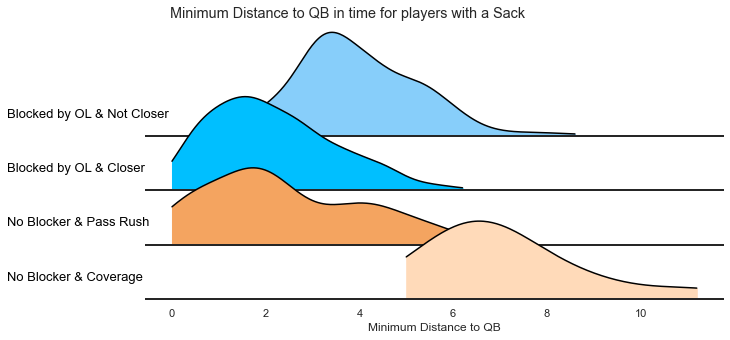

In [334]:
c1 = (def_players_sum2['sack'] == 1)
c2 = (def_players_sum2['position'].isin(['DE','DT','ILB','MLB','NT','OLB']))

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = ['lightskyblue','deepskyblue','sandybrown','peachpuff']
#palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(def_players_sum2[c1&c2], palette=palette, row="summary", hue="summary", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="dis_to_QB_round", cut=0, fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="dis_to_QB_round", cut=0, color='black')
def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.24, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "summary")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
#g.set_xlim(-4, 14)
g.set(yticks=[], xlabel="Minimum Distance to QB")
g.despine( left=True)
plt.suptitle('Minimum Distance to QB in time for players with a Sack', y=0.98)

# model attempt

In [55]:
def_start = def_players[def_players['frame_post_snap'] == 0.0][['gameId','playId','nflId','X_normal','Y_normal']]
def_post = def_players[def_players['frame_post_snap'] == 6.0][['gameId','playId','nflId','X_normal','Y_normal']]
def_post = def_post.rename(columns={'X_normal': 'next_X_normal','Y_normal': 'next_Y_normal'})
def_loc_move = pd.merge(def_start, def_post, how='left', on=['gameId','playId','nflId'])
def_loc_move['dx'] = def_loc_move['next_X_normal']-def_loc_move['X_normal']
def_loc_move['dy'] = def_loc_move['next_Y_normal']-def_loc_move['Y_normal']
def_loc_move.head(5)

,gameId,playId,nflId,X_normal,Y_normal,next_X_normal,next_Y_normal,dx,dy
0,2021090900,97,41263.0,1.12,-5.08,-0.06,-4.68,-1.18,0.40
1,2021090900,97,42403.0,1.72,8.66,0.13,7.89,-1.59,-0.77
2,2021090900,97,43306.0,2.50,5.38,2.65,5.33,0.15,-0.05
3,2021090900,97,43478.0,1.43,13.65,1.80,13.86,0.37,0.21
4,2021090900,97,44904.0,2.43,12.39,2.57,11.11,0.14,-1.28


In [56]:
trial_model_input = pd.merge(def_players_sum2, def_start, how='left', on=['gameId','playId','nflId'])
trial_model_input = trial_model_input[['gameId','playId','nflId','X_normal','Y_normal','clean_pressure','clean_sack']]

trial_model_input2 = pd.merge(def_players_sum2, def_loc_move, how='left', on=['gameId','playId','nflId'])
trial_model_input2 = trial_model_input2[['gameId','playId','nflId','X_normal','Y_normal','dx','dy','down','yardsToGo','Shotgun','play_action','assigned_blockers','total_reciever2','clean_pressure']]
trial_model_input2.head(20)

,gameId,playId,nflId,X_normal,Y_normal,dx,dy,down,yardsToGo,Shotgun,play_action,assigned_blockers,total_reciever2,clean_pressure
0,2021090900,97,41263.0,1.12,-5.08,-1.18,0.40,3,2,1,0,0,4,0
1,2021090900,97,42403.0,1.72,8.66,-1.59,-0.77,3,2,1,0,1,4,0
2,2021090900,97,43306.0,2.50,5.38,0.15,-0.05,3,2,1,0,0,4,0
3,2021090900,97,43478.0,1.43,13.65,0.37,0.21,3,2,1,0,0,4,0
4,2021090900,97,44904.0,2.43,12.39,0.14,-1.28,3,2,1,0,0,4,0
5,2021090900,97,44955.0,1.17,1.21,-1.00,0.22,3,2,1,0,2,4,0
6,2021090900,97,44962.0,16.81,3.21,1.03,-0.07,3,2,1,0,0,4,0
7,2021090900,97,47996.0,5.89,-1.56,-0.33,-0.83,3,2,1,0,0,4,0
8,2021090900,97,52459.0,1.17,-8.09,0.41,-0.23,3,2,1,0,0,4,0
9,2021090900,97,53441.0,1.50,-2.04,-1.20,0.39,3,2,1,0,2,4,1


In [57]:
# Importing relevant moduals for evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

# Legacy code to predict if pass rush 
# (Not used in model, can run and skip to next section)

In [58]:
trial_model_input3 = pd.merge(trial_model_input2, pff[['gameId','playId','nflId','pass_rush']], how='left', on = ['gameId','playId','nflId'])
trial_model_input3.head(5)

,gameId,playId,nflId,X_normal,Y_normal,dx,dy,down,yardsToGo,Shotgun,play_action,assigned_blockers,total_reciever2,clean_pressure,pass_rush
0,2021090900,97,41263.0,1.12,-5.08,-1.18,0.40,3,2,1,0,0,4,0,1
1,2021090900,97,42403.0,1.72,8.66,-1.59,-0.77,3,2,1,0,1,4,0,1
2,2021090900,97,43306.0,2.50,5.38,0.15,-0.05,3,2,1,0,0,4,0,0
3,2021090900,97,43478.0,1.43,13.65,0.37,0.21,3,2,1,0,0,4,0,0
4,2021090900,97,44904.0,2.43,12.39,0.14,-1.28,3,2,1,0,0,4,0,0


In [59]:
# Importing relevant moduals for evaluation
from sklearn.model_selection import train_test_split

# Reducing main data set excluding outliers down to the relevant variables for the model
#model_set_pr = trial_model_input3[['gameId','playId','nflId','X_normal','Y_normal','dx','dy','pass_rush']]
model_set_pr = trial_model_input3[['X_normal','Y_normal','dx','dy','pass_rush']]
#model_set_pr = trial_model_input2[['gameId','playId','nflId','X_normal','Y_normal','dx','dy','down','yardsToGo','shotgun','play_action','total_reciever2','clean_pressure']]
X_pr = model_set_pr.iloc[:, :-1].values
Y_pr = model_set_pr.iloc[:, -1].values

# Creation of training and test groups
X_train_pr, X_test_pr, Y_train_pr, Y_test_pr = train_test_split(X_pr, Y_pr, test_size = 0.2, random_state = 0)

import xgboost as xgb
xgb_clf_pr = xgb.XGBClassifier()
xgb_clf_pr = xgb_clf_pr.fit(X_train_pr, Y_train_pr)

print(xgb_clf_pr.predict(X_test_pr))
print(xgb_clf_pr.predict_proba(X_test_pr))

[1 0 1 ... 1 1 1]
[[3.9732456e-03 9.9602675e-01]
 [9.9999696e-01 3.0307529e-06]
 [1.2526512e-03 9.9874735e-01]
 ...
 [3.4263551e-02 9.6573645e-01]
 [2.8703511e-02 9.7129649e-01]
 [5.8341026e-04 9.9941659e-01]]


In [60]:
#trialio2 = trial_model_input[(trial_model_input['gameId'] == 2021090900)&(trial_model_input['playId'] == 97)][['X_normal','Y_normal','clean_pressure','clean_sack']]
#trialio3 = trial_model_input3[(trial_model_input3['gameId'] == 2021090900)&(trial_model_input3['playId'] == 187)][['gameId','playId','nflId','X_normal','Y_normal','dx','dy','pass_rush']]
trialio3 = trial_model_input3[(trial_model_input3['gameId'] == 2021090900)&(trial_model_input3['playId'] == 187)][['X_normal','Y_normal','dx','dy','pass_rush']]
#trialio3 = trial_model_input2[(trial_model_input2['gameId'] == 2021090900)&(trial_model_input2['playId'] == 187)][['gameId','playId','nflId','X_normal','Y_normal','dx','dy','down','yardsToGo','shotgun','play_action','total_reciever2','clean_pressure']]

X_t3 = trialio3.iloc[:, :-1].values
y_t_pred_probs3 = xgb_clf_pr.predict_proba(X_t3)

r_t3 = pd.DataFrame(y_t_pred_probs3, columns = ['non_pressure','pressure'])
trialio3.reset_index( drop=False, inplace=True )
trialio3['non_pressure_pred'] = r_t3['non_pressure']
trialio3['pressure_pred'] = r_t3['pressure']
trialio3['pressure_pred'] = trialio3['pressure_pred'].round(4)
trialio3['pass_rush_pred'] = xgb_clf_pr.predict(X_t3)
trialio3

,index,X_normal,Y_normal,dx,dy,pass_rush,non_pressure_pred,pressure_pred,pass_rush_pred
0,22,2.23,-2.14,-1.03,-0.22,1,0.060176,0.9398,1
1,23,1.26,5.18,-1.07,0.00,1,0.001118,0.9989,1
2,24,4.86,1.43,-0.51,-0.02,1,0.433615,0.5664,1
3,25,2.15,-5.46,0.15,-0.32,0,0.997872,0.0021,0
4,26,2.18,0.94,-0.73,-0.02,1,0.128733,0.8713,1
5,27,8.04,-11.73,0.94,-1.17,0,1.000000,0.0000,0
6,28,5.22,-1.21,0.12,0.07,0,0.999870,0.0001,0
7,29,6.75,-5.94,0.91,-1.34,0,0.999999,0.0000,0
8,30,7.13,13.60,0.33,1.14,0,0.999999,0.0000,0
9,31,9.14,5.22,-0.79,0.61,0,0.998826,0.0012,0


In [61]:
check_model_input_x = pd.DataFrame(X_test_pr, columns = ['X_normal','Y_normal','dx','dy'])
check_model_input_y = pd.DataFrame(Y_test_pr, columns = ['pass_rush'])
check_model_pred_class = pd.DataFrame(xgb_clf_pr.predict(X_test_pr), columns = ['pass_rush_pred'])
check_model_pred_class_prob = pd.DataFrame(xgb_clf_pr.predict_proba(X_test_pr), columns = ['non_pass_rush_pred_pct','pass_rush_pred_pct'])

check_model_input_x['act_pass_rush'] = check_model_input_y['pass_rush']
check_model_input_x['pass_rush_pred'] = check_model_pred_class['pass_rush_pred']
check_model_input_x['non_pass_rush_pred_pct'] = check_model_pred_class_prob['non_pass_rush_pred_pct']
check_model_input_x['pass_rush_pred_pct'] = check_model_pred_class_prob['pass_rush_pred_pct']

check_model_input_x['pass_rush_pred2'] = np.where(check_model_pred_class_prob['pass_rush_pred_pct']> 0.1,1,0)
#check_model_input_x['gameId'] = check_model_input_x['gameId'].astype('int64') 
#check_model_input_x = pd.merge(check_model_input_x, ob_red, how='left', left_on=['X_normal','Y_normal','snp_dis_to_def','pos_dis_to_def','dis_to_def_pct_diff','act_blocked'], right_on=['X_normal','Y_normal','snp_dis_to_def','pos_dis_to_def','dis_to_def_pct_diff','blocked'])
check_model_input_x.head(15)
#check_model_input_x[check_model_input_x['act_reciever2'] != check_model_input_x['pred_reciever2']].head(15)

,X_normal,Y_normal,dx,dy,act_pass_rush,pass_rush_pred,non_pass_rush_pred_pct,pass_rush_pred_pct,pass_rush_pred2
0,1.36,-1.98,-0.99,-0.29,1,1,0.003973,0.996027,1
1,15.67,-7.92,0.90,0.15,0,0,0.999997,0.000003,0
2,1.30,1.23,-1.30,-0.03,1,1,0.001253,0.998747,1
3,1.57,-5.27,-0.37,0.03,1,1,0.113947,0.886053,1
4,10.97,4.58,-0.36,1.77,0,0,0.999644,0.000356,0
5,5.03,11.06,0.36,-0.35,0,0,0.999986,0.000014,0
6,0.73,-9.92,-0.80,0.28,1,1,0.002494,0.997506,1
7,13.72,7.03,0.53,-0.23,0,0,0.999923,0.000077,0
8,1.35,-1.95,-0.50,0.42,1,1,0.008675,0.991325,1
9,1.24,1.35,-0.16,-0.26,1,1,0.052959,0.947041,1


In [514]:
#model notes
# actual pass rush, predicted as no pass rush
# think the DB just reads it as run rather than rushing the passer
trial_model_input3[(trial_model_input3['X_normal'].round(2) == 3.76)&(trial_model_input3['Y_normal'].round(2) == 14.02)&(trial_model_input3['dx'].round(2) == -0.03)]
# delayed blitz
trial_model_input3[(trial_model_input3['X_normal'].round(2) == 4.93)&(trial_model_input3['Y_normal'].round(2) == 2.54)&(trial_model_input3['dx'].round(2) == -0.16)]
# blitz from far out, ideally would pick it up
trial_model_input3[(trial_model_input3['X_normal'].round(2) == 6.22)&(trial_model_input3['Y_normal'].round(2) == 4.74)&(trial_model_input3['dx'].round(2) == -1.32)]
# slightly delayed crossing blitz pass rush prediction 13%
trial_model_input3[(trial_model_input3['X_normal'].round(2) == 4.83)&(trial_model_input3['Y_normal'].round(2) == -2.49)&(trial_model_input3['dx'].round(2) == -0.38)]
# vikings defence slow to move
trial_model_input3[(trial_model_input3['X_normal'].round(2) == 2.09)&(trial_model_input3['Y_normal'].round(2) == 4.85)&(trial_model_input3['dx'].round(2) == -0.11)]
# definitely a pass rush from deep
trial_model_input3[(trial_model_input3['X_normal'].round(2) == 4.40)&(trial_model_input3['Y_normal'].round(2) == -0.96)&(trial_model_input3['dx'].round(2) == -0.49)]
# normal blitz from mlb
trial_model_input3[(trial_model_input3['X_normal'].round(2) == 4.76)&(trial_model_input3['Y_normal'].round(2) == 1.67)&(trial_model_input3['dx'].round(2) == -0.48)]
# delayed blitz, fakes coverage
trial_model_input3[(trial_model_input3['X_normal'].round(2) == 1.42)&(trial_model_input3['Y_normal'].round(2) == 7.05)&(trial_model_input3['dx'].round(2) == 0.15)]

# no pass rush, predicted as pass rush
# fake pass rush then bail into coverage
trial_model_input3[(trial_model_input3['X_normal'].round(2) == 1.06)&(trial_model_input3['Y_normal'].round(2) == -6.87)&(trial_model_input3['dx'].round(2) == -0.37)]
# fake pass rush
trial_model_input3[(trial_model_input3['X_normal'].round(2) == 1.58)&(trial_model_input3['Y_normal'].round(2) == -3.77)&(trial_model_input3['dx'].round(2) == -0.57)]
# looks like pass rush, potentially drops off as oline look like screen play
trial_model_input3[(trial_model_input3['X_normal'].round(2) == 1.48)&(trial_model_input3['Y_normal'].round(2) == 0.96)&(trial_model_input3['dx'].round(2) == -0.75)]
# for first second he is rushing the passer before dropping into coverage
trial_model_input3[(trial_model_input3['X_normal'].round(2) == 1.60)&(trial_model_input3['Y_normal'].round(2) == 5.29)&(trial_model_input3['dx'].round(2) == -0.77)]

,gameId,playId,nflId,X_normal,Y_normal,dx,dy,down,yardsToGo,shotgun,play_action,assigned_blockers,total_reciever2,clean_pressure,pass_rush


In [63]:
pr_model_input = trial_model_input3[['X_normal','Y_normal','dx','dy','pass_rush']]
all_movement = pr_model_input.iloc[:, :-1].values

import xgboost as xgb
pass_rush_prediction = xgb_clf_pr.predict_proba(all_movement)
pass_rush_prediction_df = pd.DataFrame(pass_rush_prediction, columns = ['no_pass_rush','is_pass_rush'])

trial_model_input3['no_pass_rush'] = pass_rush_prediction_df['no_pass_rush']
trial_model_input3['is_pass_rush'] = pass_rush_prediction_df['is_pass_rush']
trial_model_input3['over_pass_rush_threshold'] = np.where(trial_model_input3['is_pass_rush'] >= 0.1,1,0)
trial_model_input3.head(5)

,gameId,playId,nflId,X_normal,Y_normal,dx,dy,down,yardsToGo,Shotgun,play_action,assigned_blockers,total_reciever2,clean_pressure,pass_rush,no_pass_rush,is_pass_rush,over_pass_rush_threshold
0,2021090900,97,41263.0,1.12,-5.08,-1.18,0.40,3,2,1,0,0,4,0,1,0.000739,0.999261,1
1,2021090900,97,42403.0,1.72,8.66,-1.59,-0.77,3,2,1,0,1,4,0,1,0.005285,0.994715,1
2,2021090900,97,43306.0,2.50,5.38,0.15,-0.05,3,2,1,0,0,4,0,0,0.984176,0.015824,0
3,2021090900,97,43478.0,1.43,13.65,0.37,0.21,3,2,1,0,0,4,0,0,0.999988,0.000012,0
4,2021090900,97,44904.0,2.43,12.39,0.14,-1.28,3,2,1,0,0,4,0,0,0.955824,0.044176,0


In [65]:
trial_model_input4 = pd.merge(trial_model_input3, game_data[['gameId','week']], how='left', left_on=['gameId'], right_on=['gameId'])
trial_model_input4['d_X_normal'] = trial_model_input4['X_normal'].round(1)
trial_model_input4['d_Y_normal'] = trial_model_input4['Y_normal'].round(1)
trial_model_input4['dd_X_normal'] = ((trial_model_input4['X_normal']*5).round(0))/5
trial_model_input4['dd_Y_normal'] = ((trial_model_input4['Y_normal']*5).round(0))/5
trial_model_input4['d_dx'] = trial_model_input4['dx'].round(1)
trial_model_input4['d_dy'] = trial_model_input4['dy'].round(1)
trial_model_input4['dd_dx'] = ((trial_model_input4['dx']*5).round(0))/5
trial_model_input4['dd_dy'] = ((trial_model_input4['dy']*5).round(0))/5

trial_model_input4['dx_mod'] = np.where(trial_model_input4['dx'] < 0 ,trial_model_input4['dx']*-1,trial_model_input4['dx'])
trial_model_input4['dy_mod'] = np.where(trial_model_input4['dy'] < 0 ,trial_model_input4['dy']*-1,trial_model_input4['dy'])
trial_model_input4['pr_raw_degrees']= np.rad2deg(np.arctan2(trial_model_input4['dy_mod'],trial_model_input4['dx_mod']))

##vices count
deg_dir_conditions = [
    ((trial_model_input4['dx'] <= 0)&(trial_model_input4['dy'] <= 0)),
    ((trial_model_input4['dx'] <= 0)&(trial_model_input4['dy'] > 0)),
    ((trial_model_input4['dx'] > 0)&(trial_model_input4['dy'] <= 0)),
    ((trial_model_input4['dx'] > 0)&(trial_model_input4['dy'] > 0)),
    ]
deg_dir_values = [(180-trial_model_input4['pr_raw_degrees']), (180+trial_model_input4['pr_raw_degrees']), (0+trial_model_input4['pr_raw_degrees']),(360-trial_model_input4['pr_raw_degrees']) ]

trial_model_input4['pr_direction'] = np.select(deg_dir_conditions, deg_dir_values)
trial_model_input4['d_pr_direction'] = trial_model_input4['pr_direction'].round(0)
trial_model_input4['dd_pr_direction'] = ((trial_model_input4['pr_direction']/10).round(0))*10
trial_model_input4 = pd.merge(trial_model_input4, players[['nflId','officialPosition']], how='left', left_on=['nflId'], right_on=['nflId'])
trial_model_input4.head(5)

,gameId,playId,nflId,X_normal,Y_normal,dx,dy,down,yardsToGo,Shotgun,play_action,assigned_blockers,total_reciever2,clean_pressure,pass_rush,no_pass_rush,is_pass_rush,over_pass_rush_threshold,week,d_X_normal,d_Y_normal,dd_X_normal,dd_Y_normal,d_dx,d_dy,dd_dx,dd_dy,dx_mod,dy_mod,pr_raw_degrees,pr_direction,d_pr_direction,dd_pr_direction,officialPosition
0,2021090900,97,41263.0,1.12,-5.08,-1.18,0.40,3,2,1,0,0,4,0,1,0.000739,0.999261,1,1,1.1,-5.1,1.2,-5.0,-1.2,0.4,-1.2,0.4,1.18,0.40,18.725788,198.725788,199.0,200.0,DE
1,2021090900,97,42403.0,1.72,8.66,-1.59,-0.77,3,2,1,0,1,4,0,1,0.005285,0.994715,1,1,1.7,8.7,1.8,8.6,-1.6,-0.8,-1.6,-0.8,1.59,0.77,25.839827,154.160173,154.0,150.0,DE
2,2021090900,97,43306.0,2.50,5.38,0.15,-0.05,3,2,1,0,0,4,0,0,0.984176,0.015824,0,1,2.5,5.4,2.4,5.4,0.1,-0.1,0.2,-0.0,0.15,0.05,18.434949,18.434949,18.0,20.0,MLB
3,2021090900,97,43478.0,1.43,13.65,0.37,0.21,3,2,1,0,0,4,0,0,0.999988,0.000012,0,1,1.4,13.6,1.4,13.6,0.4,0.2,0.4,0.2,0.37,0.21,29.577839,330.422161,330.0,330.0,CB
4,2021090900,97,44904.0,2.43,12.39,0.14,-1.28,3,2,1,0,0,4,0,0,0.955824,0.044176,0,1,2.4,12.4,2.4,12.4,0.1,-1.3,0.2,-1.2,0.14,1.28,83.758086,83.758086,84.0,80.0,CB


In [159]:
t_1 = trial_model_input4
t_1['diff'] = t_1['Y_normal']-t_1['dd_Y_normal']
t_1['mod_diff'] = np.where(t_1['diff'] < 0, t_1['diff']*-1,t_1['diff'])
t_1['mod_diff'].mean()

0.05000053312861195

# Final Model

In [344]:
# Importing relevant moduals for evaluation
from sklearn.model_selection import train_test_split

#trial_model_input5 = trial_model_input4[(trial_model_input4['officialPosition'].isin(['DE','DT','ILB','MLB','NT','OLB']))&(trial_model_input4['pass_rush'] == 1)]

trial_model_input5 = trial_model_input4

# final model
week_1_6_train_set = trial_model_input5[trial_model_input5['week'].isin([1,2,3,4,5,6])][['dd_X_normal','dd_Y_normal','dd_pr_direction','down','Shotgun','play_action','assigned_blockers','total_reciever2','clean_pressure']]
week_7_8_train_set = trial_model_input5[trial_model_input5['week'].isin([7,8])][['X_normal','Y_normal','pr_direction','down','Shotgun','play_action','assigned_blockers','total_reciever2','clean_pressure']]
week_1_6_train_setv2 = trial_model_input5[trial_model_input5['week'].isin([1,2,3,4,5,6])][['X_normal','Y_normal','pr_direction','down','Shotgun','play_action','assigned_blockers','total_reciever2','clean_pressure']]

#week_1_6_train_set = trial_model_input5[trial_model_input5['week'].isin([1,2,3,4,5,6,7,8])][['dd_X_normal','dd_Y_normal','dd_pr_direction','down','Shotgun','play_action','assigned_blockers','total_reciever2','clean_pressure']]
#week_7_8_train_set = trial_model_input5[trial_model_input5['week'].isin([7,8])][['X_normal','Y_normal','pr_direction','down','Shotgun','play_action','assigned_blockers','total_reciever2','clean_pressure']]
#week_1_6_train_setv2 = trial_model_input5[trial_model_input5['week'].isin([1,2,3,4,5,6,7,8])][['X_normal','Y_normal','pr_direction','down','Shotgun','play_action','assigned_blockers','total_reciever2','clean_pressure']]


X_train_press = week_1_6_train_set.iloc[:, :-1].values
Y_train_press = week_1_6_train_set.iloc[:, -1].values

X_test_press = week_7_8_train_set.iloc[:, :-1].values
Y_test_press = week_7_8_train_set.iloc[:, -1].values

X_train_press2 = week_1_6_train_setv2.iloc[:, :-1].values
Y_train_press2 = week_1_6_train_setv2.iloc[:, -1].values

import xgboost as xgb
xgb_clf_press = xgb.XGBClassifier()
xgb_clf_press= xgb_clf_press.fit(X_train_press, Y_train_press)

print(xgb_clf_press.predict(X_test_press))
print(xgb_clf_press.predict_proba(X_test_press))

[0 0 0 ... 0 0 0]
[[9.9995476e-01 4.5215365e-05]
 [9.5678896e-01 4.3211043e-02]
 [9.8843902e-01 1.1560972e-02]
 ...
 [9.9999756e-01 2.4720073e-06]
 [9.9999595e-01 4.0328473e-06]
 [8.6558276e-01 1.3441722e-01]]


In [345]:
week_1_6_train_set.head(1)

,dd_X_normal,dd_Y_normal,dd_pr_direction,down,Shotgun,play_action,assigned_blockers,total_reciever2,clean_pressure
0,1.2,-5.0,200.0,3,1,0,0,4,0


In [346]:
week_7_8_train_set.head(1)

,X_normal,Y_normal,pr_direction,down,Shotgun,play_action,assigned_blockers,total_reciever2,clean_pressure
72424,9.9,5.72,143.426969,1,0,1,0,4,0


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

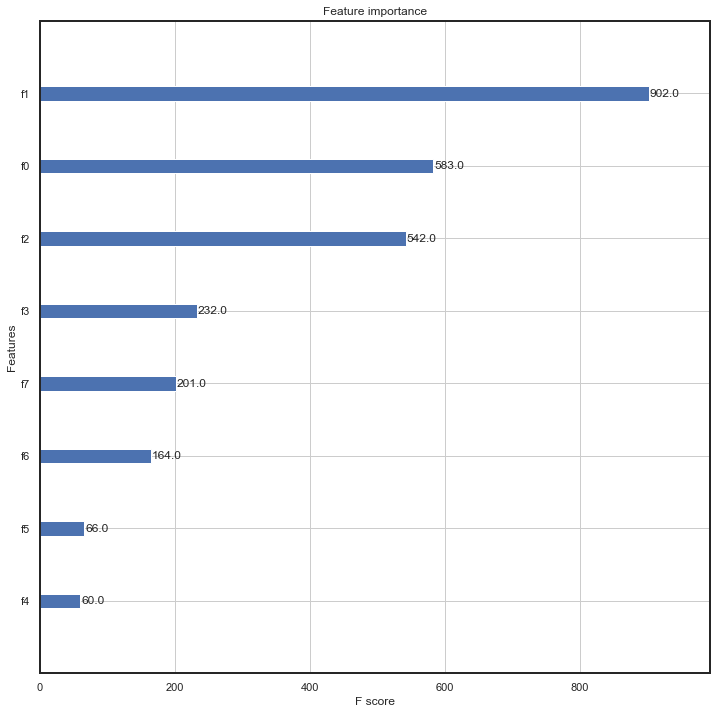

In [347]:
# feature importance training set only
xgb.plot_importance(xgb_clf_press)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

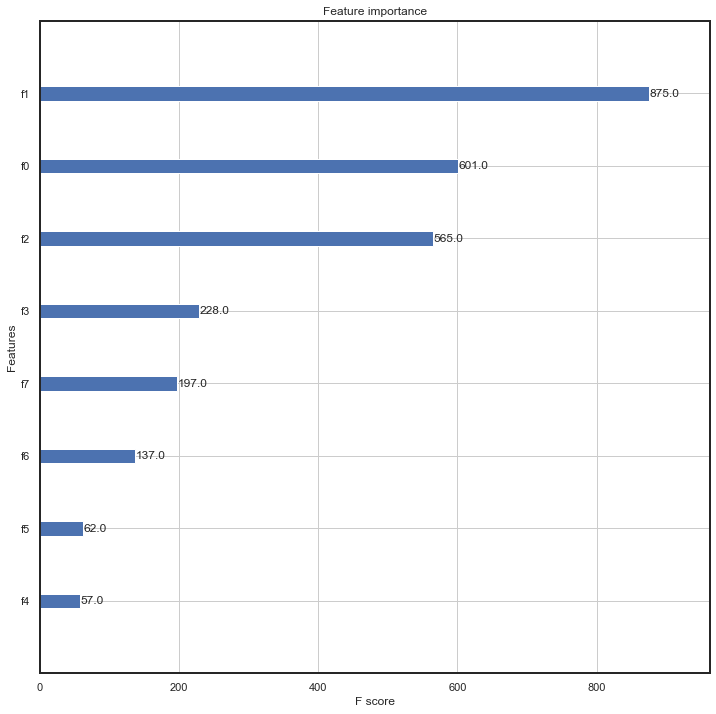

In [339]:
# feature importance training set & test set
xgb.plot_importance(xgb_clf_press)

In [199]:
eval_set = [(X_train_press, Y_train_press), (X_test_press, Y_test_press)]
xgb_clf_press.fit(X_train_press, Y_train_press, eval_metric=["error", "logloss","rmse"], eval_set=eval_set, verbose=True)
#xgb_clf_press.fit(X_train_press, Y_train_press, eval_metric=["logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.02536	validation_0-logloss:0.46167	validation_0-rmse:0.37027	validation_1-error:0.02476	validation_1-logloss:0.46151	validation_1-rmse:0.37016
[1]	validation_0-error:0.02536	validation_0-logloss:0.33487	validation_0-rmse:0.28756	validation_1-error:0.02476	validation_1-logloss:0.33464	validation_1-rmse:0.28735
[2]	validation_0-error:0.02536	validation_0-logloss:0.25640	validation_0-rmse:0.23409	validation_1-error:0.02476	validation_1-logloss:0.25620	validation_1-rmse:0.23383
[3]	validation_0-error:0.02536	validation_0-logloss:0.20518	validation_0-rmse:0.20036	validation_1-error:0.02476	validation_1-logloss:0.20506	validation_1-rmse:0.20006
[4]	validation_0-error:0.02536	validation_0-logloss:0.17073	validation_0-rmse:0.17982	validation_1-error:0.02476	validation_1-logloss:0.17071	validation_1-rmse:0.17949
[5]	validation_0-error:0.02536	validation_0-logloss:0.14716	validation_0-rmse:0.16776	validation_1-error:0.02476	validation_1-logloss:0.14722	validation_1-rmse:

[49]	validation_0-error:0.02530	validation_0-logloss:0.08578	validation_0-rmse:0.14952	validation_1-error:0.02476	validation_1-logloss:0.09200	validation_1-rmse:0.15189
[50]	validation_0-error:0.02527	validation_0-logloss:0.08560	validation_0-rmse:0.14942	validation_1-error:0.02476	validation_1-logloss:0.09200	validation_1-rmse:0.15193
[51]	validation_0-error:0.02525	validation_0-logloss:0.08544	validation_0-rmse:0.14932	validation_1-error:0.02476	validation_1-logloss:0.09192	validation_1-rmse:0.15192
[52]	validation_0-error:0.02524	validation_0-logloss:0.08532	validation_0-rmse:0.14924	validation_1-error:0.02476	validation_1-logloss:0.09195	validation_1-rmse:0.15194
[53]	validation_0-error:0.02524	validation_0-logloss:0.08515	validation_0-rmse:0.14913	validation_1-error:0.02476	validation_1-logloss:0.09196	validation_1-rmse:0.15196
[54]	validation_0-error:0.02521	validation_0-logloss:0.08487	validation_0-rmse:0.14895	validation_1-error:0.02476	validation_1-logloss:0.09205	validation_1

[98]	validation_0-error:0.02487	validation_0-logloss:0.08012	validation_0-rmse:0.14583	validation_1-error:0.02486	validation_1-logloss:0.09289	validation_1-rmse:0.15258
[99]	validation_0-error:0.02485	validation_0-logloss:0.07999	validation_0-rmse:0.14571	validation_1-error:0.02486	validation_1-logloss:0.09290	validation_1-rmse:0.15259


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

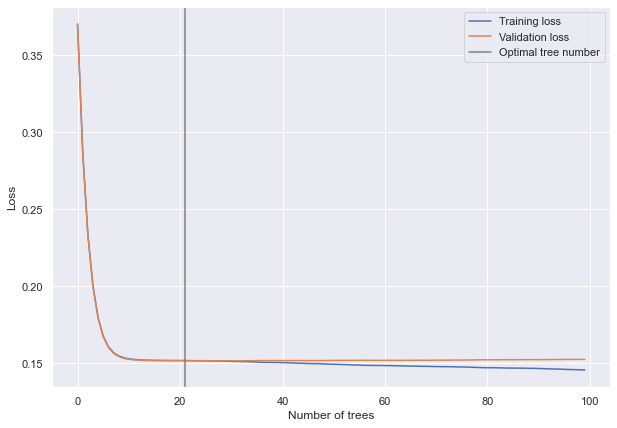

In [200]:
results = xgb_clf_press.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [312]:
week_1_6_train_set.head(5)

,dd_X_normal,dd_Y_normal,dd_pr_direction,down,Shotgun,play_action,assigned_blockers,total_reciever2,clean_pressure
0,1.2,-5.0,200.0,3,1,0,0,4,0
1,1.8,8.6,150.0,3,1,0,1,4,0
2,2.4,5.4,20.0,3,1,0,0,4,0
3,1.4,13.6,330.0,3,1,0,0,4,0
4,2.4,12.4,80.0,3,1,0,0,4,0


In [348]:
week_1_6_train_setv2['gameId'] = trial_model_input5[(trial_model_input5['week'].isin([1,2,3,4,5,6]))]['gameId']
week_1_6_train_setv2['playId'] = trial_model_input5[(trial_model_input5['week'].isin([1,2,3,4,5,6]))]['playId']
week_1_6_train_setv2['nflId'] = trial_model_input5[(trial_model_input5['week'].isin([1,2,3,4,5,6]))]['nflId']

pred_1_6 = xgb_clf_press.predict_proba(X_train_press2)
pred_1_6_df = pd.DataFrame(pred_1_6, columns = ['non_pressure_pred','pressure_pred'])

week_1_6_train_setv2.reset_index( drop=False, inplace=True )
week_1_6_train_setv2['non_pressure_pred'] = pred_1_6_df['non_pressure_pred']
week_1_6_train_setv2['pressure_pred'] = pred_1_6_df['pressure_pred']
week_1_6_train_setv2['pressure_over_50'] = np.where(week_1_6_train_setv2['pressure_pred']>0.5,1,0)
week_1_6_train_setv2['pressure_over_30'] = np.where(week_1_6_train_setv2['pressure_pred']>0.3,1,0)
week_1_6_train_setv2['pressure_over_20'] = np.where(week_1_6_train_setv2['pressure_pred']>0.2,1,0)
week_1_6_train_setv2 = pd.merge(week_1_6_train_setv2, players[['nflId','officialPosition','displayName']], how='left', on=['nflId'])
week_1_6_train_setv2.head(5)

,index,X_normal,Y_normal,pr_direction,down,Shotgun,play_action,assigned_blockers,total_reciever2,clean_pressure,gameId,playId,nflId,non_pressure_pred,pressure_pred,pressure_over_50,pressure_over_30,pressure_over_20,officialPosition,displayName
0,0,1.12,-5.08,198.725788,3,1,0,0,4,0,2021090900,97,41263.0,0.902352,0.097648,0,0,0,DE,Demarcus Lawrence
1,1,1.72,8.66,154.160173,3,1,0,1,4,0,2021090900,97,42403.0,0.976894,0.023106,0,0,0,DE,Randy Gregory
2,2,2.50,5.38,18.434949,3,1,0,0,4,0,2021090900,97,43306.0,0.999930,0.000070,0,0,0,MLB,Keanu Neal
3,3,1.43,13.65,330.422161,3,1,0,0,4,0,2021090900,97,43478.0,0.999991,0.000009,0,0,0,CB,Anthony Brown
4,4,2.43,12.39,83.758086,3,1,0,0,4,0,2021090900,97,44904.0,0.999904,0.000096,0,0,0,CB,Jourdan Lewis


In [349]:
week_7_8_train_set['gameId'] = trial_model_input5[(trial_model_input5['week'].isin([7,8]))]['gameId']
week_7_8_train_set['playId'] = trial_model_input5[(trial_model_input5['week'].isin([7,8]))]['playId']
week_7_8_train_set['nflId'] = trial_model_input5[(trial_model_input5['week'].isin([7,8]))]['nflId']

pred_7_8 = xgb_clf_press.predict_proba(X_test_press)
pred_7_8_df = pd.DataFrame(pred_7_8, columns = ['non_pressure_pred','pressure_pred'])

week_7_8_train_set.reset_index( drop=False, inplace=True )
week_7_8_train_set['non_pressure_pred'] = pred_7_8_df['non_pressure_pred']
week_7_8_train_set['pressure_pred'] = pred_7_8_df['pressure_pred']
week_7_8_train_set = pd.merge(week_7_8_train_set, players[['nflId','officialPosition','displayName']], how='left', on=['nflId'])
week_7_8_train_set.head(5)

,index,X_normal,Y_normal,pr_direction,down,Shotgun,play_action,assigned_blockers,total_reciever2,clean_pressure,gameId,playId,nflId,non_pressure_pred,pressure_pred,officialPosition,displayName
0,72424,9.90,5.72,143.426969,1,0,1,0,4,0,2021102100,56,35459.0,0.999955,0.000045,SS,Kareem Jackson
1,72425,1.22,-5.30,167.005383,1,0,1,2,4,0,2021102100,56,37075.0,0.956789,0.043211,OLB,Von Miller
2,72426,1.45,-1.31,114.863697,1,0,1,1,4,0,2021102100,56,40347.0,0.988439,0.011561,NT,Mike Purcell
3,72427,1.32,2.63,131.185925,1,0,1,2,4,0,2021102100,56,41464.0,0.972843,0.027157,DE,Shelby Harris
4,72428,6.40,9.39,90.725224,1,0,1,0,4,0,2021102100,56,42393.0,0.999700,0.000300,CB,Ronald Darby


In [350]:
#model_review2 = week_7_8_train_set[week_7_8_train_set['officialPosition'].isin(['DE','DT','NT'])]
model_review2 = week_7_8_train_set
model_review2['pressure_pred_round'] = model_review2['pressure_pred'].round(2)

model_review3 = model_review2.groupby(['pressure_pred_round']).agg({'clean_pressure':'sum','playId':'count'})
model_review3.reset_index( drop=False, inplace=True )
model_review3['actual_pressure'] = model_review3['clean_pressure']/model_review3['playId']
model_review3['cum_playId'] = model_review3['playId'].cumsum()
model_review3['total_playId'] = model_review3['playId'].sum()

model_review3['cum_freq'] = model_review3['cum_playId']/model_review3['total_playId']
model_review3['pct_freq'] = model_review3['playId']/model_review3['total_playId']
model_review3['set'] = 'Test'

(0.0, 0.3)

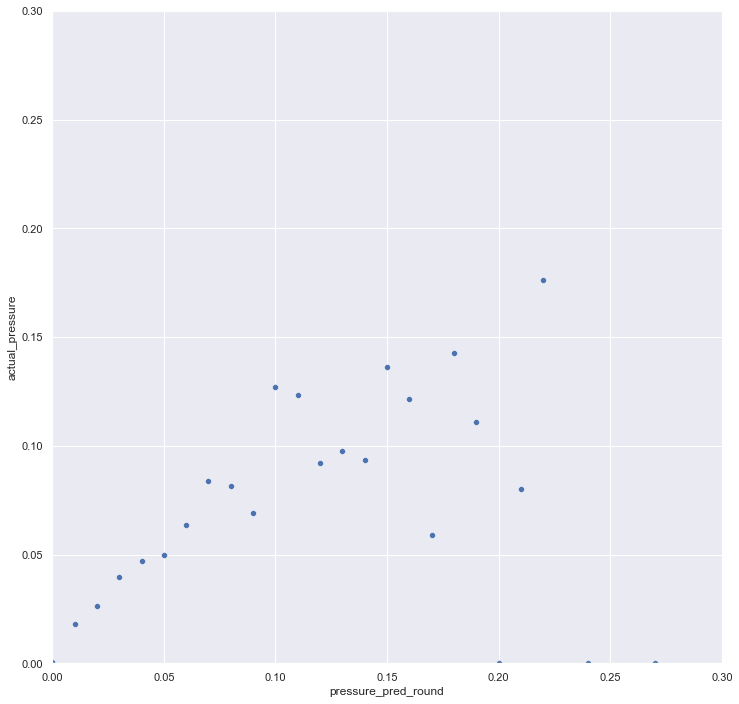

In [351]:
sns.set(rc={'figure.figsize':(12,12)})
c = sns.scatterplot(data=model_review3[model_review3['playId']>=10], x = 'pressure_pred_round' , y = 'actual_pressure')
c.set_xlim(0, 0.3)
c.set_ylim(0, 0.3)

In [352]:
#model_review22 = week_1_6_train_setv2[week_1_6_train_setv2['officialPosition'].isin(['DE','DT','NT'])]
model_review22 = week_1_6_train_setv2
model_review22['pressure_pred_round'] = model_review22['pressure_pred'].round(2)

model_review33 = model_review22.groupby(['pressure_pred_round']).agg({'clean_pressure':'sum','playId':'count'})
model_review33.reset_index( drop=False, inplace=True )
model_review33['actual_pressure'] = model_review33['clean_pressure']/model_review33['playId']

model_review33['cum_playId'] = model_review33['playId'].cumsum()
model_review33['total_playId'] = model_review33['playId'].sum()

model_review33['cum_freq'] = model_review33['cum_playId']/model_review33['total_playId']
model_review33['pct_freq'] = model_review33['playId']/model_review33['total_playId']
model_review33['set'] = 'Train'

In [353]:
# manually importing the comine 40 time from wikipedia or google
pressure_pred_round = [0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30]
actual_pressure = [0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30]
d = {'pressure_pred_round': pressure_pred_round, 'actual_pressure': actual_pressure}
d_line = pd.DataFrame(data=d)
d_line['clean_pressure'] = 0
d_line['playId'] = 100
d_line['cum_playId'] = 0
d_line['total_playId'] = 0
d_line['cum_freq'] = 0
d_line['pct_freq'] = 0
d_line['set'] = 'Equal'
d_line = d_line[['pressure_pred_round','clean_pressure','playId','actual_pressure','cum_playId','total_playId','cum_freq','set']]
d_line.head(5)

,pressure_pred_round,clean_pressure,playId,actual_pressure,cum_playId,total_playId,cum_freq,set
0,0.00,0,100,0.00,0,0,0,Equal
1,0.01,0,100,0.01,0,0,0,Equal
2,0.02,0,100,0.02,0,0,0,Equal
3,0.03,0,100,0.03,0,0,0,Equal
4,0.04,0,100,0.04,0,0,0,Equal


In [354]:
model_review333 = pd.concat([model_review3,model_review33,d_line])
model_review333['Actual Pressure'] = model_review333['actual_pressure']
model_review333['Predicted Pressure'] = model_review333['pressure_pred_round']
model_review333['Cumulative Frequency'] = model_review333['cum_freq']
model_review333['Set'] = np.where(model_review333['set'] == 'Test','Test Set','Other')
model_review333['Set'] = np.where(model_review333['set'] == 'Train','Raw Training Set',model_review333['Set'])
model_review333['Set'] = np.where(model_review333['set'] == 'Equal','Perfect Performance',model_review333['Set'])
model_review333 = model_review333.sort_values(['Set','pressure_pred_round'], ascending = [True,True])
model_review333.head(10)

,pressure_pred_round,clean_pressure,playId,actual_pressure,cum_playId,total_playId,cum_freq,pct_freq,set,Actual Pressure,Predicted Pressure,Cumulative Frequency,Set
0,0.00,0,100,0.00,0,0,0.0,NaN,Equal,0.00,0.00,0.0,Perfect Performance
1,0.01,0,100,0.01,0,0,0.0,NaN,Equal,0.01,0.01,0.0,Perfect Performance
2,0.02,0,100,0.02,0,0,0.0,NaN,Equal,0.02,0.02,0.0,Perfect Performance
3,0.03,0,100,0.03,0,0,0.0,NaN,Equal,0.03,0.03,0.0,Perfect Performance
4,0.04,0,100,0.04,0,0,0.0,NaN,Equal,0.04,0.04,0.0,Perfect Performance
5,0.05,0,100,0.05,0,0,0.0,NaN,Equal,0.05,0.05,0.0,Perfect Performance
6,0.06,0,100,0.06,0,0,0.0,NaN,Equal,0.06,0.06,0.0,Perfect Performance
7,0.07,0,100,0.07,0,0,0.0,NaN,Equal,0.07,0.07,0.0,Perfect Performance
8,0.08,0,100,0.08,0,0,0.0,NaN,Equal,0.08,0.08,0.0,Perfect Performance
9,0.09,0,100,0.09,0,0,0.0,NaN,Equal,0.09,0.09,0.0,Perfect Performance


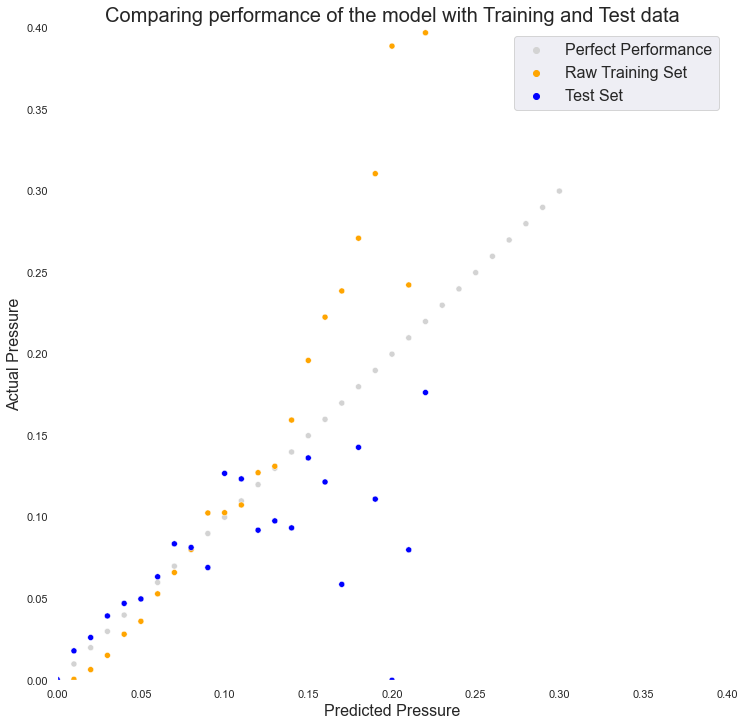

In [424]:
#after
sns.set(rc={'figure.figsize':(12,12)})
c = sns.scatterplot(data=model_review333[model_review333['playId']>=15], x = 'Predicted Pressure' , y = 'Actual Pressure', hue = 'Set',palette=['lightgrey','orange','blue'])
c.axes.set_title("Comparing performance of the model with Training and Test data",fontsize=20)
c.set_xlabel("Predicted Pressure",fontsize=16)
c.set_ylabel("Actual Pressure",fontsize=16)
c.set_facecolor("white")
c.set_xlim(0, 0.4)
c.set_ylim(0, 0.4)
plt.legend(prop={'size': 16})

(0.0, 1.0)

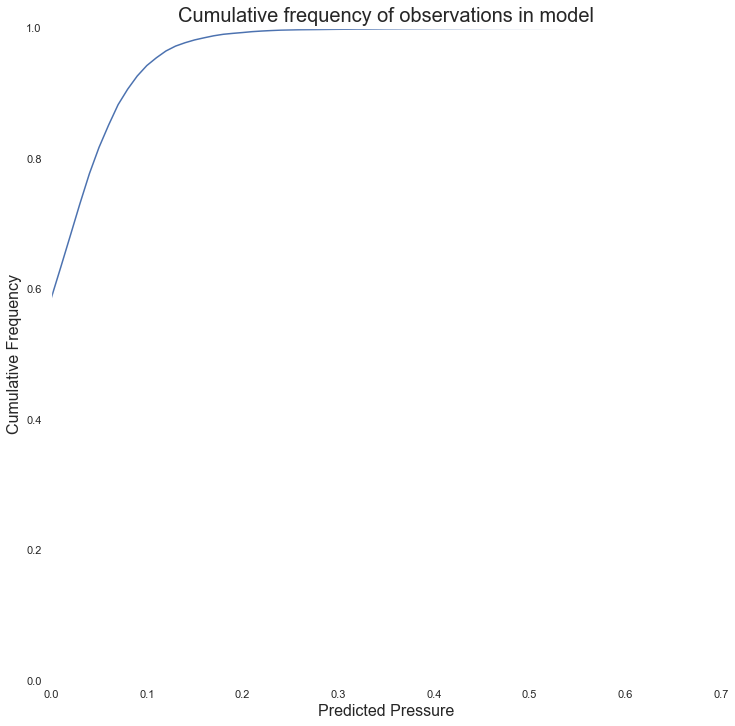

In [358]:
sns.set(rc={'figure.figsize':(12,12)})
c = sns.lineplot(data=model_review333[model_review333['Set'] == 'Raw Training Set'], x = 'Predicted Pressure' , y = 'Cumulative Frequency',palette=['black'])
c.axes.set_title("Cumulative frequency of observations in model",fontsize=20)
c.set_xlabel("Predicted Pressure",fontsize=16)
c.set_ylabel("Cumulative Frequency",fontsize=16)
c.set_facecolor("white")
c.set_xlim(0, 0.7)
c.set_ylim(0, 1.0)

<AxesSubplot:xlabel='Y_normal', ylabel='X_normal'>

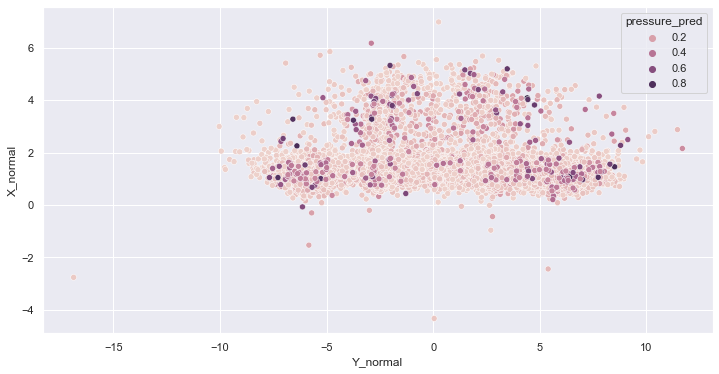

In [167]:
#chartio = week_7_8_train_set[(week_7_8_train_set['officialPosition'].isin(['DE','DT','NT']))&(week_7_8_train_set['pressure_pred'] > 0.3)].sort_values(['pressure_pred'], ascending = True)
#chartio = week_1_6_train_setv2[(week_1_6_train_setv2['officialPosition'].isin(['DE','DT','NT']))].sort_values(['pressure_over_30'], ascending = True)
chartio = week_1_6_train_setv2.sort_values(['pressure_over_30'], ascending = True)
sns.set(rc={'figure.figsize':(12,6)})
sns.scatterplot(data=chartio, x = (chartio['Y_normal']*-1) , y = 'X_normal'
                ,hue='pressure_pred')

<AxesSubplot:xlabel='Y_normal', ylabel='X_normal'>

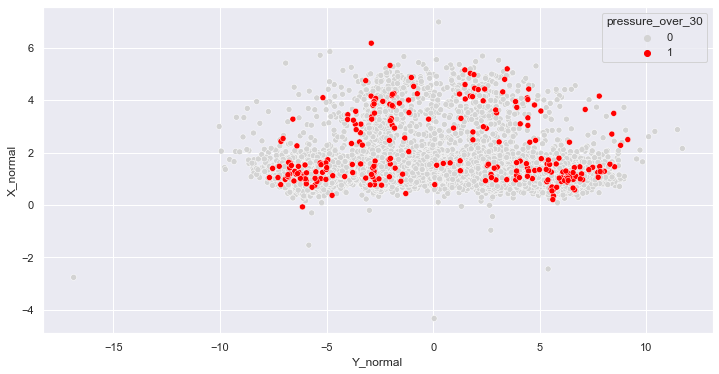

In [168]:
chartio = week_1_6_train_setv2[week_1_6_train_setv2['officialPosition'].isin(['DE','DT','NT','OLB','MLB','ILB'])].sort_values(['pressure_over_30'], ascending = True)
#chartio = week_1_6_train_setv2.sort_values(['pressure_over_30'], ascending = True)
sns.set(rc={'figure.figsize':(12,6)})
sns.scatterplot(data=chartio, x = (chartio['Y_normal']*-1) , y = 'X_normal'
                ,hue='pressure_over_30'
               ,palette=['lightgrey','red'])

In [209]:
c1 = (week_7_8_train_set['pressure_pred'] <= 0.02)
c2 = (week_7_8_train_set['pressure_pred'] >= 0.01)
c3 = (week_7_8_train_set['X_normal'] <= 1.5)
c4 = (week_7_8_train_set['Y_normal'] >= 0.5)
c5 = (week_7_8_train_set['Y_normal'] <= 2.0)

low_3 = week_7_8_train_set[c1&c2]
low_3[low_3['assigned_blockers'] == 2].groupby(['clean_pressure']).count()

,index,X_normal,Y_normal,pr_direction,down,Shotgun,play_action,assigned_blockers,total_reciever2,gameId,playId,nflId,non_pressure_pred,pressure_pred,officialPosition,displayName,pressure_pred_round
clean_pressure,,,,,,,,,,,,,,,,,
0,547,547,547,547,547,547,547,547,547,547,547,547,547,547,547,547,547
1,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14


In [215]:
print(14/(14+547))

0.024955436720142603


In [210]:
c1 = (week_1_6_train_setv2['pressure_pred'] <= 0.02)
c2 = (week_1_6_train_setv2['pressure_pred'] >= 0.01)
c3 = (week_1_6_train_setv2['X_normal'] <= 1.5)
c4 = (week_1_6_train_setv2['Y_normal'] >= 0.5)
c5 = (week_1_6_train_setv2['Y_normal'] <= 2.0)

low_4 = week_1_6_train_setv2[c1&c2]
low_4[low_4['assigned_blockers'] == 2].groupby(['clean_pressure']).count()

,index,X_normal,Y_normal,pr_direction,down,Shotgun,play_action,assigned_blockers,total_reciever2,gameId,playId,nflId,non_pressure_pred,pressure_pred,pressure_over_50,pressure_over_30,pressure_over_20,officialPosition,displayName,pressure_pred_round
clean_pressure,,,,,,,,,,,,,,,,,,,,
0,1907,1907,1907,1907,1907,1907,1907,1907,1907,1907,1907,1907,1907,1907,1907,1907,1907,1907,1907,1907
1,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


In [216]:
print(5/(5+1907))

0.002615062761506276


In [211]:
low_4.groupby(['assigned_blockers']).count()

,index,X_normal,Y_normal,pr_direction,down,Shotgun,play_action,total_reciever2,clean_pressure,gameId,playId,nflId,non_pressure_pred,pressure_pred,pressure_over_50,pressure_over_30,pressure_over_20,officialPosition,displayName,pressure_pred_round
assigned_blockers,,,,,,,,,,,,,,,,,,,,
0,791,791,791,791,791,791,791,791,791,791,791,791,791,791,791,791,791,791,791,791
1,706,706,706,706,706,706,706,706,706,706,706,706,706,706,706,706,706,706,706,706
2,1912,1912,1912,1912,1912,1912,1912,1912,1912,1912,1912,1912,1912,1912,1912,1912,1912,1912,1912,1912


In [213]:
print(1912/(791+706+1912))

0.5608682898210618


In [212]:
low_3.groupby(['assigned_blockers']).count()

,index,X_normal,Y_normal,pr_direction,down,Shotgun,play_action,total_reciever2,clean_pressure,gameId,playId,nflId,non_pressure_pred,pressure_pred,officialPosition,displayName,pressure_pred_round
assigned_blockers,,,,,,,,,,,,,,,,,
0,242,242,242,242,242,242,242,242,242,242,242,242,242,242,242,242,242
1,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213
2,561,561,561,561,561,561,561,561,561,561,561,561,561,561,561,561,561


In [214]:
print(561/(242+213+561))

0.5521653543307087


In [366]:
trialio_1 = trial_model_input4[['X_normal','Y_normal','pr_direction','down','Shotgun','play_action','assigned_blockers','total_reciever2','clean_pressure','pass_rush','over_pass_rush_threshold','gameId','playId','nflId','yardsToGo','dx','dy']]


X_t_1 = trialio_1.iloc[:, :-9].values
y_t_pred_probs_1 = xgb_clf_press.predict_proba(X_t_1)

r_t_1 = pd.DataFrame(y_t_pred_probs_1, columns = ['non_pressure','pressure'])
trialio_1.reset_index( drop=False, inplace=True )
trialio_1['non_pressure_pred'] = r_t_1['non_pressure']
trialio_1['pressure_pred'] = r_t_1['pressure']
trialio_1['pressure_pred'] = trialio_1['pressure_pred'].round(4)
trialio_1['pressure_pred'] = np.where(trialio_1['pass_rush'] == 0,0,trialio_1['pressure_pred'])
trialio_1['u_playId'] = trialio_1['gameId'].astype(str) + "|" + trialio_1['playId'].astype(str)
trialio_1.head(22)

,index,X_normal,Y_normal,pr_direction,down,Shotgun,play_action,assigned_blockers,total_reciever2,clean_pressure,pass_rush,over_pass_rush_threshold,gameId,playId,nflId,yardsToGo,dx,dy,non_pressure_pred,pressure_pred,u_playId
0,0,1.12,-5.08,198.725788,3,1,0,0,4,0,1,1,2021090900,97,41263.0,2,-1.18,0.40,0.902352,0.0976,2021090900|97
1,1,1.72,8.66,154.160173,3,1,0,1,4,0,1,1,2021090900,97,42403.0,2,-1.59,-0.77,0.976894,0.0231,2021090900|97
2,2,2.50,5.38,18.434949,3,1,0,0,4,0,0,0,2021090900,97,43306.0,2,0.15,-0.05,0.999930,0.0000,2021090900|97
3,3,1.43,13.65,330.422161,3,1,0,0,4,0,0,0,2021090900,97,43478.0,2,0.37,0.21,0.999991,0.0000,2021090900|97
4,4,2.43,12.39,83.758086,3,1,0,0,4,0,0,0,2021090900,97,44904.0,2,0.14,-1.28,0.999904,0.0000,2021090900|97
5,5,1.17,1.21,192.407419,3,1,0,2,4,0,1,1,2021090900,97,44955.0,2,-1.00,0.22,0.975712,0.0243,2021090900|97
6,6,16.81,3.21,3.887910,3,1,0,0,4,0,0,0,2021090900,97,44962.0,2,1.03,-0.07,0.999986,0.0000,2021090900|97
7,7,5.89,-1.56,111.682292,3,1,0,0,4,0,0,0,2021090900,97,47996.0,2,-0.33,-0.83,0.999902,0.0000,2021090900|97
8,8,1.17,-8.09,29.291362,3,1,0,0,4,0,0,0,2021090900,97,52459.0,2,0.41,-0.23,0.999992,0.0000,2021090900|97
9,9,1.50,-2.04,198.004162,3,1,0,2,4,1,1,1,2021090900,97,53441.0,2,-1.20,0.39,0.946259,0.0537,2021090900|97


# Results off all weeks

In [369]:
trialio_1 = pd.merge(trialio_1, pff[['gameId','playId','nflId','pressure']], how='left', on=['gameId','playId','nflId'])
trialio_1 = pd.merge(trialio_1, plays[['gameId','playId','possessionTeam','defensiveTeam']], how='left', on=['gameId','playId'])
trialio_1 = trialio_1.rename(columns={'pressure': 'any_pressure'})
trialio_1.head(5)

,index,X_normal,Y_normal,pr_direction,down,Shotgun,play_action,assigned_blockers,total_reciever2,clean_pressure,pass_rush,over_pass_rush_threshold,gameId,playId,nflId,yardsToGo,dx,dy,non_pressure_pred,pressure_pred,u_playId,any_pressure,possessionTeam,defensiveTeam
0,0,1.12,-5.08,198.725788,3,1,0,0,4,0,1,1,2021090900,97,41263.0,2,-1.18,0.40,0.902352,0.0976,2021090900|97,1,TB,DAL
1,1,1.72,8.66,154.160173,3,1,0,1,4,0,1,1,2021090900,97,42403.0,2,-1.59,-0.77,0.976894,0.0231,2021090900|97,1,TB,DAL
2,2,2.50,5.38,18.434949,3,1,0,0,4,0,0,0,2021090900,97,43306.0,2,0.15,-0.05,0.999930,0.0000,2021090900|97,0,TB,DAL
3,3,1.43,13.65,330.422161,3,1,0,0,4,0,0,0,2021090900,97,43478.0,2,0.37,0.21,0.999991,0.0000,2021090900|97,0,TB,DAL
4,4,2.43,12.39,83.758086,3,1,0,0,4,0,0,0,2021090900,97,44904.0,2,0.14,-1.28,0.999904,0.0000,2021090900|97,0,TB,DAL


In [370]:
trialio_results = trialio_1[trialio_1['pass_rush'] == 1].groupby(['nflId','defensiveTeam']).agg({'pressure_pred':'sum','clean_pressure':'sum','any_pressure':'sum','u_playId':'nunique'})
trialio_results.reset_index( drop=False, inplace=True )
trialio_results['pressure_over_pred'] = trialio_results['clean_pressure'] - trialio_results['pressure_pred']
trialio_results['hustle_pressure'] = trialio_results['any_pressure'] - trialio_results['clean_pressure']
#trialio_results['p_p_per_play'] = trialio_results['pressure_pred']/trialio_results['playId']
#trialio_results['p_over_p_per_play'] = trialio_results['pressure_over_pred']/trialio_results['playId']
trialio_results['pressure_rank'] = trialio_results['pressure_over_pred'].rank(method="first", ascending=False)

trialio_results_wn = pd.merge(trialio_results, players[['nflId','officialPosition','displayName']], how='left', left_on=['nflId'], right_on=['nflId'])
trialio_results_wn.sort_values(['pressure_rank'], ascending = True).head(30)

,nflId,defensiveTeam,pressure_pred,clean_pressure,any_pressure,u_playId,pressure_over_pred,hustle_pressure,pressure_rank,officialPosition,displayName
244,44813.0,CLE,15.790500,32,50,208,16.209500,18,1.0,DE,Myles Garrett
213,43435.0,NE,15.306500,31,42,189,15.693500,11,2.0,OLB,Matt Judon
108,41915.0,TB,16.301800,30,42,220,13.698200,12,3.0,OLB,Shaquil Barrett
251,44829.0,WAS,11.453900,24,35,218,12.546100,11,4.0,DT,Jonathan Allen
200,43378.0,PHI,8.030200,20,26,169,11.969800,6,5.0,DT,Javon Hargrave
84,41239.0,LA,14.127300,26,37,258,11.872700,11,6.0,DT,Aaron Donald
11,35470.0,BUF,8.978400,20,28,133,11.021600,8,7.0,DE,Jerry Hughes
281,44915.0,CIN,15.023700,24,45,216,8.976300,21,8.0,DE,Trey Hendrickson
332,46110.0,TEN,17.072500,26,40,220,8.927500,14,9.0,OLB,Harold Landry
18,37075.0,DEN,13.121300,21,30,159,7.878700,9,10.0,OLB,Von Miller


In [371]:
ind_pr_results = trialio_results_wn
ind_pr_results = ind_pr_results[ind_pr_results['officialPosition'].isin(['DE','DT','ILB','MLB','NT','OLB'])]
ind_pr_results = ind_pr_results[ind_pr_results['u_playId'] >= 20]

ind_pr_results['pressure_rank'] = ind_pr_results['pressure_over_pred'].rank(method="first", ascending=False)

ind_pr_results['Team'] = ind_pr_results['defensiveTeam']
ind_pr_results['Player'] = ind_pr_results['displayName']
ind_pr_results['Position'] = ind_pr_results['officialPosition']
ind_pr_results['Pressure Over Expected'] = ind_pr_results['pressure_over_pred']
ind_pr_results['Pressure Rank'] = ind_pr_results['pressure_rank']

ind_pr_results['Pass Rush Snaps'] = ind_pr_results['u_playId']
ind_pr_results['Pred Pressure'] = ind_pr_results['pressure_pred'].astype('float64')
ind_pr_results['Pressure In Time'] = ind_pr_results['clean_pressure']
ind_pr_results['Hustle Pressure'] = ind_pr_results['hustle_pressure']
ind_pr_results.head(5)

,nflId,defensiveTeam,pressure_pred,clean_pressure,any_pressure,u_playId,pressure_over_pred,hustle_pressure,pressure_rank,officialPosition,displayName,Team,Player,Position,Pressure Over Expected,Pressure Rank,Pass Rush Snaps,Pred Pressure,Pressure In Time,Hustle Pressure
0,33131.0,BAL,10.3062,14,20,193,3.6938,6,49.0,DE,Calais Campbell,BAL,Calais Campbell,DE,3.6938,49.0,193,10.3062,14,6
3,34777.0,TB,2.8421,1,3,52,-1.8421,2,261.0,NT,Steve McLendon,TB,Steve McLendon,NT,-1.8421,261.0,52,2.8421,1,2
4,35441.0,TB,11.4224,12,19,210,0.5776,7,119.0,DE,Ndamukong Suh,TB,Ndamukong Suh,DE,0.5776,119.0,210,11.4224,12,7
6,35449.0,PIT,1.2015,1,2,36,-0.2015,1,161.0,DE,Tyson Alualu,PIT,Tyson Alualu,DE,-0.2015,161.0,36,1.2015,1,1
7,35452.0,PHI,2.7500,2,2,28,-0.7500,0,194.0,DE,Brandon Graham,PHI,Brandon Graham,DE,-0.7500,194.0,28,2.7500,2,0


In [373]:
ind_pr_results_red = ind_pr_results[['Team','Player','Position','Pressure Over Expected','Pressure Rank','Pass Rush Snaps','Pred Pressure','Pressure In Time','Hustle Pressure']]
ind_pr_results_red = ind_pr_results_red.sort_values(['Pressure Rank'], ascending = True)
ind_pr_results_red['Pressure Over Expected'] = ind_pr_results_red['Pressure Over Expected'].round(1)
ind_pr_results_red['Pred Pressure'] = ind_pr_results_red['Pred Pressure'].round(1)
ind_pr_results_red.head(30)

,Team,Player,Position,Pressure Over Expected,Pressure Rank,Pass Rush Snaps,Pred Pressure,Pressure In Time,Hustle Pressure
244,CLE,Myles Garrett,DE,16.2,1.0,208,15.8,32,18
213,NE,Matt Judon,OLB,15.7,2.0,189,15.3,31,11
108,TB,Shaquil Barrett,OLB,13.7,3.0,220,16.3,30,12
251,WAS,Jonathan Allen,DT,12.5,4.0,218,11.5,24,11
200,PHI,Javon Hargrave,DT,12.0,5.0,169,8.0,20,6
84,LA,Aaron Donald,DT,11.9,6.0,258,14.1,26,11
11,BUF,Jerry Hughes,DE,11.0,7.0,133,9.0,20,8
281,CIN,Trey Hendrickson,DE,9.0,8.0,216,15.0,24,21
332,TEN,Harold Landry,OLB,8.9,9.0,220,17.1,26,14
18,DEN,Von Miller,OLB,7.9,10.0,159,13.1,21,9


In [374]:
ind_pr_results_red.to_csv(r'/Users/cgiess/Downloads/nfl-big-data-bowl-2023/PR_ind_results.csv', index=False)

In [471]:
trialio_results_wn[(trialio_results_wn['defensiveTeam'] == 'LV')&(trialio_results_wn['pressure_pred'] > 1)].sort_values(['pressure_pred'], ascending = False).head(30)

,nflId,defensiveTeam,pressure_pred,clean_pressure,any_pressure,u_playId,pressure_over_pred,hustle_pressure,pressure_rank,officialPosition,displayName
559,47889.0,LV,18.3538,25,49,218,6.6462,24,17.0,DE,Maxx Crosby
234,43358.0,LV,15.2513,21,30,198,5.7487,9,23.0,DE,Yannick Ngakoue
260,43436.0,LV,9.1643,7,17,163,-2.1643,10,812.0,DT,Quinton Jefferson
296,44815.0,LV,7.9358,8,21,128,0.0642,13,266.0,DT,Solomon Thomas
232,43354.0,LV,6.4196,7,9,75,0.5804,2,204.0,DE,Carl Nassib
71,39997.0,LV,5.4173,3,6,120,-2.4173,3,824.0,NT,Johnathan Hankins
513,47787.0,LV,4.1336,2,5,53,-2.1336,3,809.0,DE,Clelin Ferrell
182,42535.0,LV,3.9577,5,8,75,1.0423,3,125.0,DT,Darius Philon
94,40608.0,LV,2.2910,1,5,49,-1.2910,4,751.0,NT,Damion Square
525,47810.0,LV,2.0918,3,3,275,0.9082,0,146.0,SS,Johnathan Abram


In [375]:
team_summary = trialio_1.groupby(['defensiveTeam']).agg({'pressure_pred':'sum','clean_pressure':'sum','any_pressure':'sum','u_playId':'nunique'})
team_summary.reset_index( drop=False, inplace=True )
team_summary['pressure_over_pred'] = team_summary['clean_pressure'] - team_summary['pressure_pred']
team_summary['hustle_pressure'] = team_summary['any_pressure'] - team_summary['clean_pressure']
team_summary['hustle_pressure_pp'] = team_summary['hustle_pressure']/ team_summary['u_playId']
team_summary['pressure_over_pred_pp'] = team_summary['pressure_over_pred']/ team_summary['u_playId']
team_summary.sort_values(['hustle_pressure_pp'], ascending = True)

,defensiveTeam,pressure_pred,clean_pressure,any_pressure,u_playId,pressure_over_pred,hustle_pressure,hustle_pressure_pp,pressure_over_pred_pp
1,ATL,58.479500,59,90,227,0.520500,31,0.136564,0.002293
12,HOU,56.306900,67,104,229,10.693100,37,0.161572,0.046695
24,NYJ,73.412804,78,118,246,4.587196,40,0.162602,0.018647
25,PHI,69.574097,82,127,257,12.425903,45,0.175097,0.048350
19,MIA,80.998802,103,155,295,22.001198,52,0.176271,0.074580
13,IND,63.471001,68,119,265,4.528999,51,0.192453,0.017091
4,CAR,73.807602,94,145,262,20.192398,51,0.194656,0.077070
2,BAL,68.099098,73,125,258,4.900902,52,0.201550,0.018996
0,ARI,68.081703,71,127,265,2.918297,56,0.211321,0.011012
17,LAC,59.490501,57,105,227,-2.490501,48,0.211454,-0.010971


# Judging Scheme vs Players

In [378]:
secondary_results = trialio_1.groupby(['defensiveTeam']).agg({'any_pressure':'sum','clean_pressure':'sum','pressure_pred':'sum','pass_rush':'sum','u_playId':'nunique'})
secondary_results.reset_index( drop=False, inplace=True )
secondary_results['passing_plays'] = secondary_results['u_playId']
secondary_results['pass_rush_per_passing_play'] = secondary_results['pass_rush']/secondary_results['passing_plays']
secondary_results['pressure_pred_per_pass_play'] = secondary_results['pressure_pred']/secondary_results['passing_plays']
secondary_results['pressure_pred_per_pass_rush'] = secondary_results['pressure_pred'] / secondary_results['pass_rush']
secondary_results['clean_pressure_over_expected'] = secondary_results['clean_pressure'] - secondary_results['pressure_pred']
secondary_results['clean_pressure_over_expected_per_pass_play'] = secondary_results['clean_pressure_over_expected']/secondary_results['passing_plays']
secondary_results['clean_pressure_per_pass_play'] = secondary_results['clean_pressure']/secondary_results['passing_plays']
secondary_results['hustle_pressure'] = secondary_results['any_pressure'] - secondary_results['clean_pressure']
secondary_results['hustle_pressure_per_pass_play'] = secondary_results['hustle_pressure']/secondary_results['passing_plays']
secondary_results.head(5)

,defensiveTeam,any_pressure,clean_pressure,pressure_pred,pass_rush,u_playId,passing_plays,pass_rush_per_passing_play,pressure_pred_per_pass_play,pressure_pred_per_pass_rush,clean_pressure_over_expected,clean_pressure_over_expected_per_pass_play,clean_pressure_per_pass_play,hustle_pressure,hustle_pressure_per_pass_play
0,ARI,127,71,68.081703,1147,265,265,4.328302,0.256912,0.059356,2.918297,0.011012,0.267925,56,0.211321
1,ATL,90,59,58.479500,934,227,227,4.114537,0.257619,0.062612,0.520500,0.002293,0.259912,31,0.136564
2,BAL,125,73,68.099098,1132,258,258,4.387597,0.263950,0.060158,4.900902,0.018996,0.282946,52,0.201550
3,BUF,152,74,64.580002,1045,248,248,4.213710,0.260403,0.061799,9.419998,0.037984,0.298387,78,0.314516
4,CAR,145,94,73.807602,1149,262,262,4.385496,0.281708,0.064236,20.192398,0.077070,0.358779,51,0.194656


In [379]:
secondary_results.sort_values(['clean_pressure_over_expected'], ascending = False).head(32)

,defensiveTeam,any_pressure,clean_pressure,pressure_pred,pass_rush,u_playId,passing_plays,pass_rush_per_passing_play,pressure_pred_per_pass_play,pressure_pred_per_pass_rush,clean_pressure_over_expected,clean_pressure_over_expected_per_pass_play,clean_pressure_per_pass_play,hustle_pressure,hustle_pressure_per_pass_play
19,MIA,155,103,80.998802,1292,295,295,4.379661,0.274572,0.062693,22.001198,0.074580,0.349153,52,0.176271
4,CAR,145,94,73.807602,1149,262,262,4.385496,0.281708,0.064236,20.192398,0.077070,0.358779,51,0.194656
16,LA,171,98,81.036903,1348,316,316,4.265823,0.256446,0.060116,16.963097,0.053681,0.310127,73,0.231013
29,TB,177,101,84.936104,1432,322,322,4.447205,0.263777,0.059313,16.063896,0.049888,0.313665,76,0.236025
7,CLE,152,90,75.244202,1100,260,260,4.230769,0.289401,0.068404,14.755798,0.056753,0.346154,62,0.238462
25,PHI,127,82,69.574097,1062,257,257,4.132296,0.270716,0.065512,12.425903,0.048350,0.319066,45,0.175097
12,HOU,104,67,56.306900,957,229,229,4.179039,0.245882,0.058837,10.693100,0.046695,0.292576,37,0.161572
3,BUF,152,74,64.580002,1045,248,248,4.213710,0.260403,0.061799,9.419998,0.037984,0.298387,78,0.314516
20,MIN,132,67,57.781799,1083,253,253,4.280632,0.228387,0.053353,9.218201,0.036436,0.264822,65,0.256917
18,LV,160,85,75.928703,1124,275,275,4.087273,0.276104,0.067552,9.071297,0.032987,0.309091,75,0.272727


In [2292]:
chart_data_red = chart_data[['defensiveTeam','pressure_pred_per_pass_play','pass_rush_per_passing_play']]
from IPython.display import display
import pandas as pd

display(chart_data_red)

,defensiveTeam,pressure_pred_per_pass_play,pass_rush_per_passing_play
19,MIA,0.299016,4.379661
4,CAR,0.292774,4.385496
7,CLE,0.300317,4.230769
29,TB,0.286539,4.447205
24,NYJ,0.302115,4.360324
25,PHI,0.286876,4.132296
14,JAX,0.273442,4.286996
16,LA,0.283068,4.268139
18,LV,0.292987,4.087273
3,BUF,0.275321,4.213710


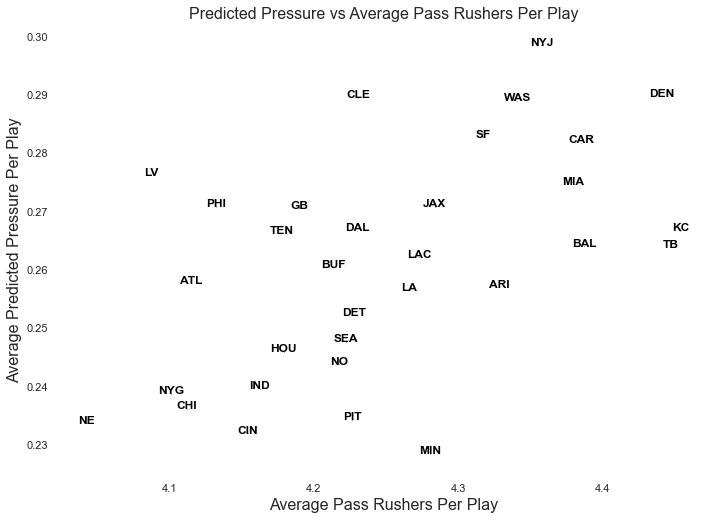

In [380]:
chart_data = secondary_results.sort_values(['pressure_pred_per_pass_play'], ascending = False)

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(data=chart_data, x="pass_rush_per_passing_play", y = "pressure_pred_per_pass_play", s = 1)
ax.set_facecolor("white")
plt.xlabel('Average Pass Rushers Per Play', fontsize=16)
plt.ylabel('Average Predicted Pressure Per Play', fontsize=16)
plt.title("Predicted Pressure vs Average Pass Rushers Per Play", fontsize=16)
# Loop through the data points 
#for i, defensiveTeam in enumerate (def_team):
#    plt.text(pass_rush_per_passing_play[i]+0.2, pressure_pred_per_pass_play[i]+0.2, defensiveTeam)

#For each point, we add a text inside the bubble
for line in range(0,chart_data.shape[0]):
     ax.text(chart_data.pass_rush_per_passing_play[line], chart_data.pressure_pred_per_pass_play[line], chart_data.defensiveTeam[line], horizontalalignment='center', size='medium', color='black', weight='semibold')
    
#plt.xticks(rotation=70)
#plt.tight_layout()

In [382]:
print(4.1*0.0896-0.1199)
print(4.4*0.0896-0.1199)

0.24745999999999996
0.27434000000000003


In [381]:
formula = 'pressure_pred_per_pass_play ~ pass_rush_per_passing_play	'
pressure_per_pass_rush = smf.glm(formula = formula, data = secondary_results, family = sm.families.Gaussian()).fit()
print(pressure_per_pass_rush.summary())

                      Generalized Linear Model Regression Results                      
Dep. Variable:     pressure_pred_per_pass_play   No. Observations:                   32
Model:                                     GLM   Df Residuals:                       30
Model Family:                         Gaussian   Df Model:                            1
Link Function:                        identity   Scale:                      0.00027362
Method:                                   IRLS   Log-Likelihood:                 86.887
Date:                         Sat, 07 Jan 2023   Deviance:                    0.0082087
Time:                                 14:52:44   Pearson chi2:                  0.00821
No. Iterations:                              3   Pseudo R-squ. (CS):             0.2979
Covariance Type:                     nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

In [383]:
secondary_results['model_predict_pressure'] = pressure_per_pass_rush.predict(secondary_results)
secondary_results['scheme_pressure'] = secondary_results['pressure_pred_per_pass_play'] - secondary_results['model_predict_pressure']
secondary_results['player_pressure'] = secondary_results['clean_pressure_per_pass_play'] - (secondary_results['model_predict_pressure']+secondary_results['scheme_pressure'])
secondary_results['player_pressure2'] = secondary_results['clean_pressure_per_pass_play'] - secondary_results['pressure_pred_per_pass_play']
secondary_results.head(5)

,defensiveTeam,any_pressure,clean_pressure,pressure_pred,pass_rush,u_playId,passing_plays,pass_rush_per_passing_play,pressure_pred_per_pass_play,pressure_pred_per_pass_rush,clean_pressure_over_expected,clean_pressure_over_expected_per_pass_play,clean_pressure_per_pass_play,hustle_pressure,hustle_pressure_per_pass_play,model_predict_pressure,scheme_pressure,player_pressure,player_pressure2
0,ARI,127,71,68.081703,1147,265,265,4.328302,0.256912,0.059356,2.918297,0.011012,0.267925,56,0.211321,0.267924,-0.011012,0.011012,0.011012
1,ATL,90,59,58.479500,934,227,227,4.114537,0.257619,0.062612,0.520500,0.002293,0.259912,31,0.136564,0.248769,0.008850,0.002293,0.002293
2,BAL,125,73,68.099098,1132,258,258,4.387597,0.263950,0.060158,4.900902,0.018996,0.282946,52,0.201550,0.273238,-0.009288,0.018996,0.018996
3,BUF,152,74,64.580002,1045,248,248,4.213710,0.260403,0.061799,9.419998,0.037984,0.298387,78,0.314516,0.257656,0.002748,0.037984,0.037984
4,CAR,145,94,73.807602,1149,262,262,4.385496,0.281708,0.064236,20.192398,0.077070,0.358779,51,0.194656,0.273049,0.008659,0.077070,0.077070


In [384]:
secondary_results_red = secondary_results[['defensiveTeam','scheme_pressure','player_pressure']]
secondary_results_red['total_pressure'] = secondary_results['scheme_pressure'] + secondary_results['player_pressure']
secondary_results_red = secondary_results_red.sort_values((['total_pressure']), ascending = False)
secondary_results_red['Scheme Pressure'] = secondary_results_red['scheme_pressure']
secondary_results_red['Player Pressure'] = secondary_results_red['player_pressure']
secondary_results_red = secondary_results_red[['defensiveTeam','Scheme Pressure','Player Pressure']]
secondary_results_red = secondary_results_red.set_index('defensiveTeam')

secondary_results_red.head(5)

,Scheme Pressure,Player Pressure
defensiveTeam,,
CLE,0.030216,0.056753
CAR,0.008659,0.077070
MIA,0.002046,0.074580
PHI,0.020356,0.048350
LV,0.029779,0.032987


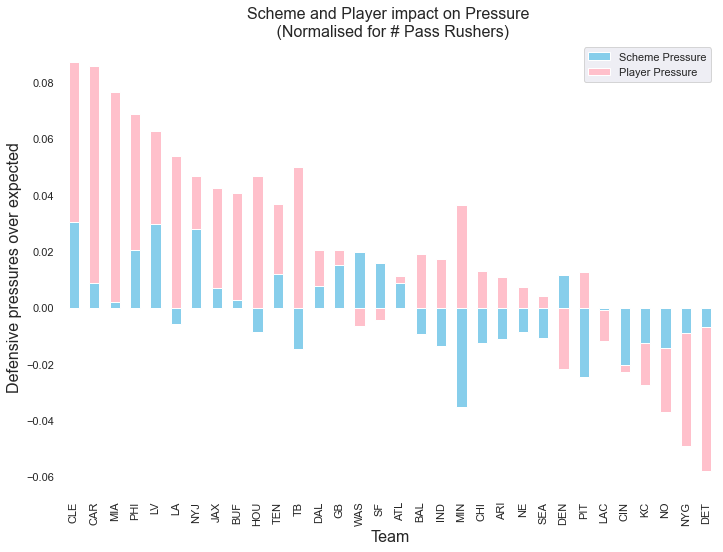

In [385]:
ax = secondary_results_red.plot.bar(stacked=True, color=['skyblue','pink'])
plt.xlabel('Team', fontsize = 16)
plt.ylabel('Defensive pressures over expected', fontsize = 16)
plt.title("Scheme and Player impact on Pressure \n (Normalised for # Pass Rushers)", fontsize = 16)
ax.set_facecolor("white")

# Judging Oline

In [386]:
oline_results = trialio_1.groupby(['possessionTeam']).agg({'any_pressure':'sum','clean_pressure':'sum','pressure_pred':'sum','pass_rush':'sum','u_playId':'nunique'})
oline_results.reset_index( drop=False, inplace=True )
oline_results['passing_plays'] = oline_results['u_playId']
oline_results['pass_rush_per_passing_play'] = oline_results['pass_rush']/oline_results['passing_plays']
oline_results['pressure_pred_per_pass_play'] = oline_results['pressure_pred']/oline_results['passing_plays']
oline_results['pressure_pred_per_pass_rush'] = oline_results['pressure_pred'] / oline_results['pass_rush']
oline_results['clean_pressure_over_expected'] = oline_results['clean_pressure'] - oline_results['pressure_pred']
oline_results['clean_pressure_over_expected_per_pass_play'] = oline_results['clean_pressure_over_expected']/oline_results['passing_plays']
oline_results['clean_pressure_per_pass_play'] = oline_results['clean_pressure']/oline_results['passing_plays']
oline_results.sort_values(['clean_pressure_over_expected'], ascending = True).head(32)

,possessionTeam,any_pressure,clean_pressure,pressure_pred,pass_rush,u_playId,passing_plays,pass_rush_per_passing_play,pressure_pred_per_pass_play,pressure_pred_per_pass_rush,clean_pressure_over_expected,clean_pressure_over_expected_per_pass_play,clean_pressure_per_pass_play
26,PIT,80,45,63.192501,987,238,238,4.147059,0.265515,0.064025,-18.192501,-0.076439,0.189076
29,TB,99,59,77.186600,1267,309,309,4.100324,0.249795,0.060921,-18.186600,-0.058856,0.190939
11,GB,101,44,57.881802,951,225,225,4.226667,0.257252,0.060864,-13.881802,-0.061697,0.195556
16,LA,83,42,54.524601,1055,249,249,4.236948,0.218974,0.051682,-12.524601,-0.050300,0.168675
8,DAL,107,56,63.073502,1145,261,261,4.386973,0.241661,0.055086,-7.073502,-0.027102,0.214559
31,WAS,145,70,76.592499,1243,298,298,4.171141,0.257022,0.061619,-6.592499,-0.022122,0.234899
15,KC,164,75,81.473900,1371,338,338,4.056213,0.241047,0.059427,-6.473900,-0.019154,0.221893
7,CLE,127,54,59.546700,1056,249,249,4.240964,0.239143,0.056389,-5.546700,-0.022276,0.216867
0,ARI,121,56,60.826698,971,233,233,4.167382,0.261059,0.062643,-4.826698,-0.020715,0.240343
5,CHI,132,67,71.259201,1065,247,247,4.311741,0.288499,0.066910,-4.259201,-0.017244,0.271255


In [511]:
c1 = (off_players['frame_post_snap'] == 0.0)
c11 = (off_players['frame_post_snap'] == 6.0)
#c1 = (off_players_df['frame_post_snap'] == 9.0)
c2 = (off_players['position'].isin(['T','G','C']))
ob_snp = off_players[c1&c2][['gameId','playId','nflId','position','displayName','jerseyNumber','X_normal','Y_normal','dx','dy','o','Orientation_deg_std','Dir_deg_std']]
ob_pos = off_players[c11&c2][['gameId','playId','nflId','X_normal','Y_normal']]
ob_pos = ob_pos.rename(columns={'X_normal': 'next_o_X_normal','Y_normal': 'next_o_Y_normal'})
ob_snp['ol_y_rank'] = ob_snp.groupby(['gameId','playId'])['Y_normal'].rank(method="first", ascending=False)
ob_snp.head(5)

,gameId,playId,nflId,position,displayName,jerseyNumber,X_normal,Y_normal,dx,dy,o,Orientation_deg_std,Dir_deg_std,ol_y_rank
177,2021090900,97,40151.0,C,Ryan Jensen,66.0,-0.08,0.05,-0.40,0.32,48.28,41.72,141.66,3.0
306,2021090900,97,42377.0,T,Donovan Smith,76.0,-0.80,2.95,-0.83,0.20,145.19,304.81,166.48,1.0
392,2021090900,97,42404.0,G,Ali Marpet,74.0,-0.25,1.68,-0.00,-0.00,107.08,342.92,199.16,2.0
693,2021090900,97,46163.0,G,Alex Cappa,65.0,-0.77,-1.34,-0.02,0.02,106.86,343.14,146.12,4.0
779,2021090900,97,52421.0,T,Tristan Wirfs,78.0,-1.07,-2.66,-0.17,-0.28,54.53,35.47,238.09,5.0


In [508]:
c1 = (def_players['frame_post_snap'] == 0.0)
c11 = (def_players['frame_post_snap'] == 6.0)
db_snp = def_players[c1][['gameId','playId','nflId','displayName','jerseyNumber','X_normal','Y_normal']]
db_snp = db_snp.rename(columns={'nflId': 'd_nflId','displayName': 'd_displayName','jerseyNumber':'d_jerseyNumber','X_normal': 'd_X_normal','Y_normal': 'd_Y_normal'})
db_pos = def_players[c11][['gameId','playId','nflId','X_normal','Y_normal']]
db_pos = db_pos.rename(columns={'nflId': 'd_nflId','X_normal': 'next_d_X_normal','Y_normal': 'next_d_Y_normal'})
db_snp.head(5)

,gameId,playId,d_nflId,d_displayName,d_jerseyNumber,d_X_normal,d_Y_normal
0,2021090900,97,41263.0,Demarcus Lawrence,90.0,1.12,-5.08
25,2021090900,97,42403.0,Randy Gregory,94.0,1.72,8.66
50,2021090900,97,43306.0,Keanu Neal,42.0,2.50,5.38
75,2021090900,97,43478.0,Anthony Brown,30.0,1.43,13.65
100,2021090900,97,44904.0,Jourdan Lewis,26.0,2.43,12.39


In [513]:
ob_snp_wb = pd.merge(ob_snp, pff[['gameId','playId','nflId','pff_nflIdBlockedPlayer']], how='left', on = ['gameId','playId','nflId'])
ob_snp_wb = pd.merge(ob_snp_wb, db_snp, how='left', left_on = ['gameId','playId','pff_nflIdBlockedPlayer'], right_on = ['gameId','playId','d_nflId'])
ob_snp_wb.head(5)

,gameId,playId,nflId,position,displayName,jerseyNumber,X_normal,Y_normal,dx,dy,o,Orientation_deg_std,Dir_deg_std,ol_y_rank,pff_nflIdBlockedPlayer,d_nflId,d_displayName,d_jerseyNumber,d_X_normal,d_Y_normal
0,2021090900,97,40151.0,C,Ryan Jensen,66.0,-0.08,0.05,-0.40,0.32,48.28,41.72,141.66,3.0,44955.0,44955.0,Carlos Watkins,91.0,1.17,1.21
1,2021090900,97,42377.0,T,Donovan Smith,76.0,-0.80,2.95,-0.83,0.20,145.19,304.81,166.48,1.0,42403.0,42403.0,Randy Gregory,94.0,1.72,8.66
2,2021090900,97,42404.0,G,Ali Marpet,74.0,-0.25,1.68,-0.00,-0.00,107.08,342.92,199.16,2.0,44955.0,44955.0,Carlos Watkins,91.0,1.17,1.21
3,2021090900,97,46163.0,G,Alex Cappa,65.0,-0.77,-1.34,-0.02,0.02,106.86,343.14,146.12,4.0,53441.0,53441.0,Micah Parsons,11.0,1.50,-2.04
4,2021090900,97,52421.0,T,Tristan Wirfs,78.0,-1.07,-2.66,-0.17,-0.28,54.53,35.47,238.09,5.0,53441.0,53441.0,Micah Parsons,11.0,1.50,-2.04


<AxesSubplot:xlabel='ol_y_rank', ylabel='d_Y_normal'>

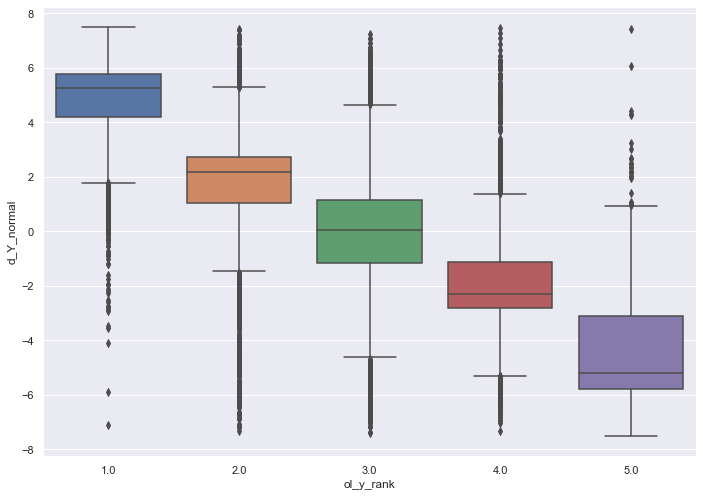

In [515]:
c1 = (ob_snp_wb['ol_y_rank'].isin([1,2,3,4,5]))
c2 = (ob_snp_wb['d_Y_normal'] <= 7.5)
c3 = (ob_snp_wb['d_Y_normal'] >= -7.5)

sns.boxplot(data = ob_snp_wb[c1&c2&c3], x = 'ol_y_rank', y = 'd_Y_normal')

In [389]:
#aligning defensive position as if it were in a standard position for the specific oline to block.
trialio_1['ol_position'] = np.where((trialio_1['Y_normal'] >= 3),1,0)
trialio_1['ol_position'] = np.where((trialio_1['ol_position'] == 0)&(trialio_1['Y_normal'] >= 1),2,trialio_1['ol_position'])
trialio_1['ol_position'] = np.where((trialio_1['ol_position'] == 0)&(trialio_1['Y_normal'] >= -1),3,trialio_1['ol_position'])
trialio_1['ol_position'] = np.where((trialio_1['ol_position'] == 0)&(trialio_1['Y_normal'] >= -3),4,trialio_1['ol_position'])
trialio_1['ol_position'] = np.where((trialio_1['ol_position'] == 0)&(trialio_1['Y_normal'] < -3),5,trialio_1['ol_position'])
trialio_1[trialio_1['over_pass_rush_threshold'] == 1].head(11)

,index,X_normal,Y_normal,pr_direction,down,Shotgun,play_action,assigned_blockers,total_reciever2,clean_pressure,pass_rush,over_pass_rush_threshold,gameId,playId,nflId,yardsToGo,dx,dy,non_pressure_pred,pressure_pred,u_playId,any_pressure,possessionTeam,defensiveTeam,ol_position
0,0,1.12,-5.08,198.725788,3,1,0,0,4,0,1,1,2021090900,97,41263.0,2,-1.18,0.40,0.902352,0.0976,2021090900|97,1,TB,DAL,5
1,1,1.72,8.66,154.160173,3,1,0,1,4,0,1,1,2021090900,97,42403.0,2,-1.59,-0.77,0.976894,0.0231,2021090900|97,1,TB,DAL,1
5,5,1.17,1.21,192.407419,3,1,0,2,4,0,1,1,2021090900,97,44955.0,2,-1.00,0.22,0.975712,0.0243,2021090900|97,0,TB,DAL,2
9,9,1.50,-2.04,198.004162,3,1,0,2,4,1,1,1,2021090900,97,53441.0,2,-1.20,0.39,0.946259,0.0537,2021090900|97,1,TB,DAL,4
10,10,1.52,2.70,182.419509,3,1,0,0,4,0,1,1,2021090900,97,53504.0,2,-0.71,0.03,0.954489,0.0455,2021090900|97,1,TB,DAL,2
11,11,2.13,3.25,149.036243,1,1,0,2,5,0,1,1,2021090900,137,35441.0,10,-1.10,-0.66,0.991633,0.0084,2021090900|137,0,DAL,TB,1
12,12,1.63,5.11,146.929322,1,1,0,1,5,0,1,1,2021090900,137,35454.0,10,-0.43,-0.28,0.982213,0.0178,2021090900|137,0,DAL,TB,1
14,14,1.67,-3.31,166.930682,1,1,0,1,5,0,1,1,2021090900,137,40074.0,10,-0.56,-0.13,0.964496,0.0355,2021090900|137,0,DAL,TB,5
16,16,0.76,-0.46,98.130102,1,1,0,1,5,0,1,1,2021090900,137,46081.0,10,-0.05,-0.35,0.998156,0.0018,2021090900|137,0,DAL,TB,3
21,21,3.35,9.23,163.779806,1,1,0,0,5,0,1,1,2021090900,137,53461.0,10,-0.55,-0.16,0.963665,0.0363,2021090900|137,0,DAL,TB,1


In [390]:
# import packages
import nfl_data_py as nfl
# load data
#df_2021 = nfl.import_pbp_data([2021])
#df_players = nfl.import_rosters([2021])
df_teams = nfl.import_team_desc()

2021 done.
Downcasting floats.


/opt/anaconda3/lib/python3.8/site-packages/nfl_data_py/__init__.py:137: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  plays.loc[:, cols] = plays.loc[:, cols].astype(numpy.float32)


In [391]:
df_teams['final_color'] = df_teams['team_color']
df_teams['final_color'] = np.where(df_teams['team_abbr'] == 'DEN',df_teams['team_color2'],df_teams['final_color'])
df_teams['final_color'] = np.where(df_teams['team_abbr'] == 'SEA',df_teams['team_color2'],df_teams['final_color'])
df_teams['final_color'] = np.where(df_teams['team_abbr'] == 'PIT',df_teams['team_color2'],df_teams['final_color'])
df_teams['final_color'] = np.where(df_teams['team_abbr'] == 'TEN',df_teams['team_color2'],df_teams['final_color'])
df_teams['final_color'] = np.where(df_teams['team_abbr'] == 'DAL',df_teams['team_color2'],df_teams['final_color'])

team_colours = df_teams[['team_abbr','final_color']]
color_pallet = pd.Series(team_colours.final_color.values,index=team_colours.team_abbr).to_dict()
color_pallet

{'ARI': '#97233F',
 'ATL': '#A71930',
 'BAL': '#241773',
 'BUF': '#00338D',
 'CAR': '#0085CA',
 'CHI': '#0B162A',
 'CIN': '#FB4F14',
 'CLE': '#FF3C00',
 'DAL': '#B0B7BC',
 'DEN': '#FB4F14',
 'DET': '#0076B6',
 'GB': '#203731',
 'HOU': '#03202F',
 'IND': '#002C5F',
 'JAX': '#006778',
 'KC': '#E31837',
 'LA': '#003594',
 'LAC': '#007BC7',
 'LAR': '#003594',
 'LV': '#000000',
 'MIA': '#008E97',
 'MIN': '#4F2683',
 'NE': '#002244',
 'NO': '#D3BC8D',
 'NYG': '#0B2265',
 'NYJ': '#003F2D',
 'OAK': '#000000',
 'PHI': '#004C54',
 'PIT': '#FFB612',
 'SD': '#007BC7',
 'SEA': '#69be28',
 'SF': '#AA0000',
 'STL': '#003594',
 'TB': '#A71930',
 'TEN': '#4B92DB',
 'WAS': '#5A1414'}

# Oline Results

In [392]:
OL_snap_position = OL3[['gameId','playId','nflId','Snap_pos']]
OL_snap_position_wb = pd.merge(OL_snap_position, pff[['gameId','playId','nflId','pff_nflIdBlockedPlayer']], how='left', on=['gameId','playId','nflId'])
OL_snap_position_wb = pd.merge(OL_snap_position_wb, trialio_1[['gameId','playId','nflId','clean_pressure','pressure_pred','any_pressure','ol_position','possessionTeam','defensiveTeam']], how='left', left_on=['gameId','playId','pff_nflIdBlockedPlayer'], right_on=['gameId','playId','nflId'])
OL_snap_position_wb = OL_snap_position_wb.rename(columns={'nflId_x': 'nflId','nflId_y': 'pr_nflId'})
OL_snap_position_wb = pd.merge(OL_snap_position_wb, players[['nflId','displayName']], how='left', left_on=['nflId'], right_on=['nflId'])
OL_snap_position_wb = pd.merge(OL_snap_position_wb, players[['nflId','displayName']], how='left', left_on=['pr_nflId'], right_on=['nflId'])
OL_snap_position_wb = OL_snap_position_wb.drop(['nflId_y'], axis=1)
OL_snap_position_wb = OL_snap_position_wb.rename(columns={'nflId_x': 'nflId','displayName_x': 'displayName','displayName_y': 'pr_displayName'})
OL_snap_position_wb['u_playId'] = OL_snap_position_wb['gameId'].astype(str) + "|" + OL_snap_position_wb['playId'].astype(str)

OL_snap_position_wb['Oline Position'] = np.where(OL_snap_position_wb['Snap_pos'] == 1,'LT','O')
OL_snap_position_wb['Oline Position'] = np.where(OL_snap_position_wb['Snap_pos'] == 2,'LG',OL_snap_position_wb['Oline Position'])
OL_snap_position_wb['Oline Position'] = np.where(OL_snap_position_wb['Snap_pos'] == 3,'C',OL_snap_position_wb['Oline Position'])
OL_snap_position_wb['Oline Position'] = np.where(OL_snap_position_wb['Snap_pos'] == 4,'RG',OL_snap_position_wb['Oline Position'])
OL_snap_position_wb['Oline Position'] = np.where(OL_snap_position_wb['Snap_pos'] == 5,'RT',OL_snap_position_wb['Oline Position'])
OL_snap_position_wb = OL_snap_position_wb[~OL_snap_position_wb['pff_nflIdBlockedPlayer'].isnull()]

OL_snap_position_wb.head(5)

,gameId,playId,nflId,Snap_pos,pff_nflIdBlockedPlayer,pr_nflId,clean_pressure,pressure_pred,any_pressure,ol_position,possessionTeam,defensiveTeam,displayName,pr_displayName,u_playId,Oline Position
0,2021090900,97,40151.0,3.0,44955.0,44955.0,0.0,0.0243,0.0,2.0,TB,DAL,Ryan Jensen,Carlos Watkins,2021090900|97,C
1,2021090900,97,42377.0,1.0,42403.0,42403.0,0.0,0.0231,1.0,1.0,TB,DAL,Donovan Smith,Randy Gregory,2021090900|97,LT
2,2021090900,97,42404.0,2.0,44955.0,44955.0,0.0,0.0243,0.0,2.0,TB,DAL,Ali Marpet,Carlos Watkins,2021090900|97,LG
3,2021090900,97,46163.0,4.0,53441.0,53441.0,1.0,0.0537,1.0,4.0,TB,DAL,Alex Cappa,Micah Parsons,2021090900|97,RG
4,2021090900,97,52421.0,5.0,53441.0,53441.0,1.0,0.0537,1.0,4.0,TB,DAL,Tristan Wirfs,Micah Parsons,2021090900|97,RT


In [393]:
team_oline_results = OL_snap_position_wb.groupby(['possessionTeam','Snap_pos','Oline Position']).agg({'pressure_pred':'sum','clean_pressure':'sum','any_pressure':'sum','u_playId':'nunique'})
team_oline_results.reset_index( drop=False, inplace=True )
team_oline_results = team_oline_results[team_oline_results['Snap_pos'].isin([1,2,3,4,5])]
team_oline_results['pressure_over_predicted'] = team_oline_results['clean_pressure'] - team_oline_results['pressure_pred'] 
team_oline_results['pressure_over_predicted_per_play'] = team_oline_results['pressure_over_predicted']/team_oline_results['u_playId']
team_oline_results['pressure_under_predicted_per_play'] = team_oline_results['pressure_over_predicted_per_play']*-1
team_oline_results.head(6)

,possessionTeam,Snap_pos,Oline Position,pressure_pred,clean_pressure,any_pressure,u_playId,pressure_over_predicted,pressure_over_predicted_per_play,pressure_under_predicted_per_play
0,ARI,1.0,LT,15.3708,19.0,31.0,232,3.6292,0.015643,-0.015643
1,ARI,2.0,LG,10.2899,8.0,21.0,232,-2.2899,-0.009870,0.009870
2,ARI,3.0,C,7.9162,3.0,14.0,225,-4.9162,-0.021850,0.021850
3,ARI,4.0,RG,10.8530,13.0,20.0,227,2.1470,0.009458,-0.009458
4,ARI,5.0,RT,15.0792,12.0,26.0,228,-3.0792,-0.013505,0.013505
6,ATL,1.0,LT,15.9490,8.0,19.0,287,-7.9490,-0.027697,0.027697


/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future v

Text(0.5, 0.98, 'Pressure Under Expected Per Play (PUE PP) by Team')

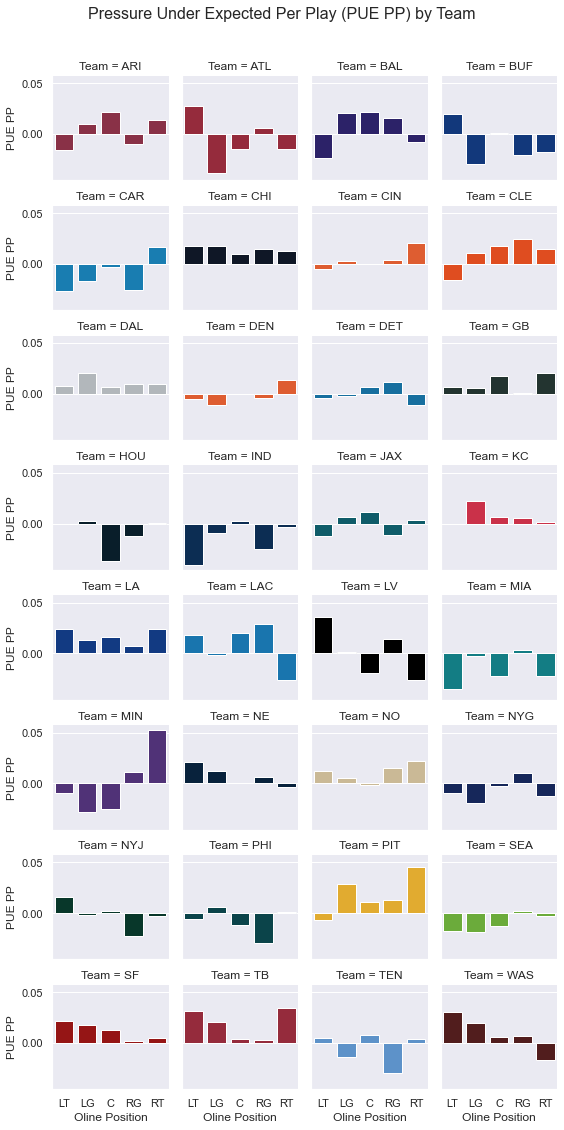

In [394]:
chart_data = team_oline_results
chart_data['Team'] = chart_data['possessionTeam']
chart_data['PUE PP'] = chart_data["pressure_under_predicted_per_play"]

g = sns.FacetGrid(chart_data, col='Team', hue = 'possessionTeam', palette = color_pallet, col_wrap=4, height=2)
g.map(sns.barplot, "Oline Position", 'PUE PP')
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Pressure Under Expected Per Play (PUE PP) by Team', fontsize=16)

In [395]:
ind_oline_resutls = OL_snap_position_wb.groupby(['nflId','displayName','possessionTeam','Snap_pos','Oline Position']).agg({'pressure_pred':'sum','clean_pressure':'sum','any_pressure':'sum','u_playId':'nunique'})
ind_oline_resutls.reset_index( drop=False, inplace=True )
ind_oline_resutls['pressure_over_predicted'] = ind_oline_resutls['clean_pressure'] - ind_oline_resutls['pressure_pred'] 
ind_oline_resutls['pressure_over_predicted_per_play'] = ind_oline_resutls['pressure_over_predicted']/ind_oline_resutls['u_playId']

#i_ol_res = ind_oline_resutls[ind_oline_resutls['u_playId'] >= 20]
i_ol_res = ind_oline_resutls[ind_oline_resutls['u_playId'] >= 100]
i_ol_res.head(5)

,nflId,displayName,possessionTeam,Snap_pos,Oline Position,pressure_pred,clean_pressure,any_pressure,u_playId,pressure_over_predicted,pressure_over_predicted_per_play
0,29550.0,Jason Peters,CHI,1.0,LT,14.5592,11.0,22.0,212,-3.5592,-0.016789
2,30869.0,Andrew Whitworth,LA,1.0,LT,9.3690,4.0,11.0,211,-5.3690,-0.025445
3,33107.0,Duane Brown,SEA,1.0,LT,12.0790,16.0,27.0,224,3.9210,0.017504
5,34472.0,Alex Mack,SF,3.0,C,8.5670,6.0,9.0,211,-2.5670,-0.012166
6,35443.0,Trent Williams,SF,1.0,LT,10.2242,6.0,11.0,169,-4.2242,-0.024995


In [396]:
ind_oline_resutls['pressure_under_predicted_per_play'] = ind_oline_resutls['pressure_over_predicted_per_play']*-1
ind_oline_resutls['Team'] = ind_oline_resutls['possessionTeam']
ind_oline_resutls['Position'] = ind_oline_resutls['Oline Position']
ind_oline_resutls['Player'] = ind_oline_resutls['displayName']
ind_oline_resutls['PUP PP'] = ind_oline_resutls['pressure_under_predicted_per_play']
ind_oline_resutls['Plays'] = ind_oline_resutls['u_playId']
ind_oline_resutls['Pred Pressure'] = ind_oline_resutls['pressure_pred']
ind_oline_resutls['Pressure In Time'] = ind_oline_resutls['clean_pressure']
ind_oline_resutls.head(5)

,nflId,displayName,possessionTeam,Snap_pos,Oline Position,pressure_pred,clean_pressure,any_pressure,u_playId,pressure_over_predicted,pressure_over_predicted_per_play,pressure_under_predicted_per_play,Team,Position,Player,PUP PP,Plays,Pred Pressure,Pressure In Time
0,29550.0,Jason Peters,CHI,1.0,LT,14.5592,11.0,22.0,212,-3.5592,-0.016789,0.016789,CHI,LT,Jason Peters,0.016789,212,14.5592,11.0
1,29550.0,Jason Peters,CHI,2.0,LG,0.2447,0.0,0.0,4,-0.2447,-0.061175,0.061175,CHI,LG,Jason Peters,0.061175,4,0.2447,0.0
2,30869.0,Andrew Whitworth,LA,1.0,LT,9.3690,4.0,11.0,211,-5.3690,-0.025445,0.025445,LA,LT,Andrew Whitworth,0.025445,211,9.3690,4.0
3,33107.0,Duane Brown,SEA,1.0,LT,12.0790,16.0,27.0,224,3.9210,0.017504,-0.017504,SEA,LT,Duane Brown,-0.017504,224,12.0790,16.0
4,34457.0,Andre Smith,BAL,1.0,LT,1.3147,0.0,0.0,19,-1.3147,-0.069195,0.069195,BAL,LT,Andre Smith,0.069195,19,1.3147,0.0


In [397]:
ind_oline_resutls_red = ind_oline_resutls[['Team','Snap_pos','Position','Player','PUP PP','Plays','Pred Pressure','Pressure In Time']]
ind_oline_resutls_red = ind_oline_resutls_red[ind_oline_resutls_red['Snap_pos'].isin([1,2,3,4,5])]
ind_oline_resutls_red = ind_oline_resutls_red[ind_oline_resutls_red['Plays'] >= 20]
ind_oline_resutls_red = ind_oline_resutls_red.sort_values(['Team','Snap_pos','Plays'], ascending = [True,True,False])
ind_oline_resutls_red = ind_oline_resutls_red[['Team','Position','Player','PUP PP','Plays','Pred Pressure','Pressure In Time']]
ind_oline_resutls_red['PUP PP'] = ind_oline_resutls_red['PUP PP'].round(3)
ind_oline_resutls_red['Pred Pressure'] = ind_oline_resutls_red['Pred Pressure'].round(1)

ind_oline_resutls_red.head(5)

,Team,Position,Player,PUP PP,Plays,Pred Pressure,Pressure In Time
108,ARI,LT,D.J. Humphries,-0.017,230,15.2,19.0
38,ARI,LG,Justin Pugh,0.007,213,9.6,8.0
15,ARI,C,Rodney Hudson,0.022,139,5.1,2.0
133,ARI,C,Max Garcia,0.036,55,2.0,0.0
214,ARI,C,Sean Harlow,-0.008,29,0.8,1.0


In [398]:
ind_oline_resutls_red.to_csv(r'/Users/cgiess/Downloads/nfl-big-data-bowl-2023/OL_ind_results.csv', index=False)